<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/MarkM/Swish_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Swish

In this section, we will investigate the Swish Activation function and assess how performance levels differ as we tune different hyperparameters. The document is structured as follows.

**Table of Contents**
- [0. Necessary Imports](#0-imports)
- [1. Requirements](#1-requirements)
    - [1.1 Data Augmentation](#11-data-augmentation)
    - [1.2 Train and Test splitting](#12-checking-for-duplicates)
    - [1.3 Train:Validation split](#13-train-validation-split)
- [2. Investigation](#2-investigation)
    - [2.1 Introduction to Swish Activation Function](#21-introduction-to-swish)
    - [2.2 Hyperparameters Tuning](#21-hyperparameters-tuning)
        - [2.2.1 Epochs and Batch Size](#221-epoch-and-batch-size)
        - [2.2.2 Learning Rate](#222-learning-rate)
        - [2.2.3 Swish learnable parameter](#2213-learnable)
- [3. Final Model Testing](#3-model-testing)
    - [3.1 Implimentation](#31-implimentation)
    - [3.2 Training](#32-training)
    - [3.3 Testing](#33-testing)
    - [3.4 Scaling Up: Impact of Training on the Full 256x256 Dataset](#34-scaling)
- [4. Conclusion](#4-conclusion)
- [5. References](#5-references)






<!-- - [2.2.2 Network Architecture](#221-network-architecture)
            - [2.2.2.1 Number of layers](#2.2.2.1-number-of-layers)
            - [2.2.2.2 Width](#2.2.2.2-width)
    - [2.3 Additional Techniques and Enhancements](#22-additional-techniques-and-enhancements)
         - INSERT -->

# 1. Requirements

Here, we import all packages required to run this file.

In [ ]:
import subprocess
import sys

# List of external packages to check/install
required_packages = [
    "numpy",
    "matplotlib",
    "tqdm",
    "opencv-python",  # Correct package name for OpenCV
    "imutils",
    "tensorflow",
    "kagglehub",
]

# Install a package using pip
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Loop through each package and ensure it's installed
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"{package} is not installed. Installing...")
        install_package(package)

# Now proceed to import all required libraries
import os
import json
import time
import hashlib
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from tqdm import tqdm
import cv2
import imutils

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import (
    ExponentialDecay,
    PiecewiseConstantDecay,
    PolynomialDecay,
    CosineDecay,
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.activations import swish

import kagglehub


# 1. Requirements

This section outlines the preprocessing pipleine that we impliment for consistency. Here, we download the data, run the preprocessing script and then run the ImageDataGen which impliments augmentation with geometric transformations (i.e flips, shears, rotations, zooms etc, and brightness, contrast changes) as outlined in our exploratory data analysis.



## 1.1 Data Augmentation



In [2]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# Convert path to a Path object
path = Path(path)

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust these labels based on your dataset's folder names

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


100%|██████████| 149M/149M [00:02<00:00, 57.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


## 1.2 Train and Test Splitting

In [3]:
# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0,  # Randomly shift RGB channels (intensity)
    validation_split=0.2  # Use 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
print('Training Data: ')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Use 'binary' for binary classification, 'categorical' otherwise
    subset = 'training',
    shuffle=True
)
print('Validation Data: ')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Use 'binary' for binary classification, 'categorical' otherwise
    subset = 'validation',
    shuffle=True
)
print('Testing Data: ')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Training Data: 
Found 4571 images belonging to 4 classes.
Validation Data: 
Found 1141 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


## 1.3 Train:Validation split

To fine-tune hyperparameters and assess their impact on performance, we will split the training data into training and validation sets. There are many factors that can influence the choice of split such as data availability and model complexity. If the validation split is too large, then the remaining training data will be substantially smaller than the entire training set and so the model may not be trained on a sufficient volume of data for convergence of performance on training data. On the other hand, if the validation split is too small, hyperparameter tuning becomes more difficult and the incites we gain become less reliable meaning that we may choose a suboptimal model that does not translate to a higher performance in testing [1]. In the above block, we select an 80/20 train/validation split which is a common split for moderately large datasets, providing ample data for training while reserving enough data for validation.

# 2. Investigation

Now all necessary preorocessing has been completed, we can commence our investigation into the swift function.



## 2.1 Introduction to the Swish Activation Function

In this section, we will establish the mathematical principles that underpin the Swish activation function and therefore justify the reasoning behind its use in this particular application.

### A formal definition

Formally, the swish activation function is defined as:

$ f(x) = x \times sigmoid(αx) = \frac{x}{1+\exp(-αx)}  $

where α is either a constant or learnable parameter [3]. The choice of the scalar, α, works to adjust the degree of nonlinearity in the swish function. For example, consider below the various plots of swish for different values of α.









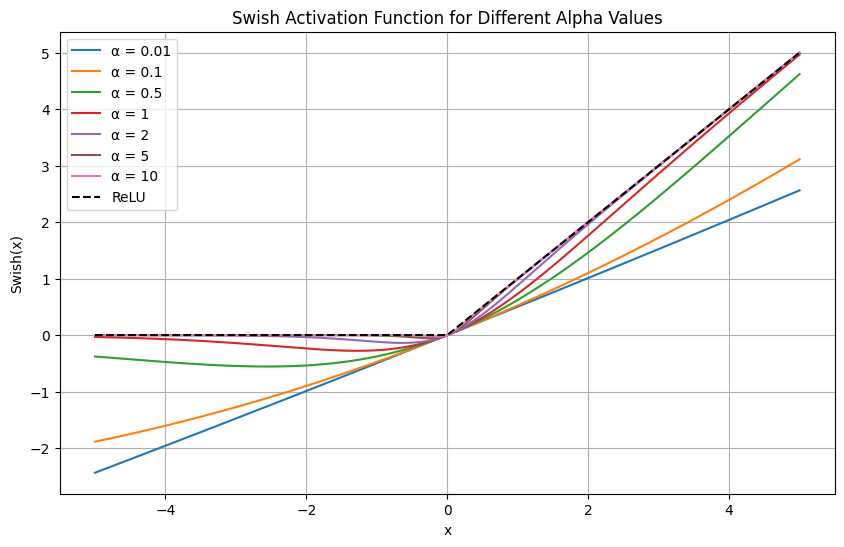

In [ ]:
# Define the Swish activation function with a variable alpha parameter
def swish_fun(x, alpha=1):
    return x * (1 / (1 + np.exp(-alpha * x)))

def relu_fun(x):
  return np.maximum(0,x)

x_values = np.linspace(-5, 5, 200) # Generate X vals

alpha_values = [0.01,0.1,0.5, 1, 2, 5, 10] # Define different alpha values

# Plot Swish activation functions for different alpha values
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    y_values = swish_fun(x_values, alpha)
    plt.plot(x_values, y_values, label=f'α = {alpha}')

plt.plot(x_values, relu_fun(x_values), label='ReLU', linestyle='--', color='black')

plt.title('Swish Activation Function for Different Alpha Values')
plt.xlabel('x')
plt.ylabel('Swish(x)')
plt.legend()
plt.grid(True)
plt.show()

As we see, as our choice of parameter tends towards 0, swish looks increasingly linear and looks like the linear function $x/2$ as $exp(-αx) ≈ 1$ hence $x/(1+exp(-αx)) ≈ x/2$.

For larger values of $α$, the swish function becomes increasingly like an indicator function. For example, for very large $α$, for negative $x$, $αx$ is large and negative and so $x/(1+exp(-αx))$ tends to 0 whereas for positive $x$, $αx$ is large and positive and so  $x/(1+exp(-αx))$ tends to $x$. With this insight, we have that swish approximates ReLU increasingly well as we increase the choice our parameter. Research of various implimentations of swish (as outlined below) suggest that $ α = 1 $ is a reasonable choice of parameter although we will consider this in our investigation later.


### Application Justification

Research of swish has shown that the activation function has shown promising performance in the domain of image classification. For example, on ImageNet, a large scale database containing millions of labeled images across thousands of categories [2], Swish has been shown to outperform ReLU, generally considered the best performing activation function in terms of accuracy [3]. Furthermore, a study by the National Institute of Technology Rourkela [4] whereby the VGG16 model, a popular CNN architecture developed out of the university of Oxford for image classificiation tasks [5] was modified with swish activation function over ReLU and showed higher levels across various performance metrics including accuracy, recall and specifictiy. Additionally, research into enhancing image classification for colorectal cancer by replacing ReLU for swish also led to improved accuracy rates.  Given Swish's proven capability in enhancing model performance on image classification tasks, it is therefore reasonable to consider Swish as a viable activation function for use in our application domain of classifying brain tumors. In order to impliment the algorithm, we will manually impliment the algorithm instead of importing it therby allowing us to manipulate and adapt the structure of the algorithm in order to perform out parameter-specific evaluations.

## 2.2 Hyper-parameter Tuning

In this section, we will perform hyperparameter tuning to assess how tweaking particular parameters within the Neural Network impact performance. In order to impliment this, we will need to a choose baseline model that we can build upon. as outlined previously, the VGG16 architecture is a popular convolution neural network architecture with 13 convolutional layers and 3 fully connected layers [5]. Let us begin by implimenting a similar model below. In order to impliment this architecture, we must modify the architecture slightly. The input shape of the original VGG16 model was images of size 224 x 224 whereas our image size is 64 x 64. To do this, we must have that inclde_top = False.

In [4]:
# Function to create the VGG16-like model with 12 convolutional layers and Swish activation
def create_vgg16_swish_model(input_shape=(64, 64, 3), num_classes=4, initial_learning_rate=0.001, lr_scheduler=None):
    model = models.Sequential()

    # Block 1: 2 Conv layers with 64 filters and Swish activation
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='swish', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: 2 Conv layers with 128 filters and Swish activation
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: 2 Conv layers with 256 filters and Swish activation
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 5: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from the last convolutional block
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(256, activation='swish'))
    model.add(layers.Dense(256, activation='swish'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax

    # Compile the model with the chosen learning rate and scheduler
    if lr_scheduler:
        model.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
base_model = create_vgg16_swish_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Print a summary of the model architecture
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,861,796 (14.73 MB)

 Trainable params: 3,861,796 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

This function displays a summary of the base model that we will study various parameters on. We see that there are several sets of convolution layers which are each followed by a pooling layer which performs dimensionality reduction by decreasing the size of our feature maps. After the convolutional layers have established areas of relevance in the photos and established the high-level features, the 3 dense layers implimented to learn complex patterns and relationships in these features. Additionally, in the base model there are roughly 4 million trainable parameters.



In [ ]:
epoch_count = 30

Initially we set our epoch count to 30 although this choice is arbitrary at this point.

In [ ]:
history = base_model.fit(train_generator,epochs=epoch_count,validation_data=validation_generator)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.2717 - loss: 1.5082 - val_accuracy: 0.3357 - val_loss: 1.3972
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.3093 - loss: 1.9465 - val_accuracy: 0.3339 - val_loss: 1.3493
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3662 - loss: 1.2934 - val_accuracy: 0.3339 - val_loss: 1.3459
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.3496 - loss: 1.2954 - val_accuracy: 0.3374 - val_loss: 1.3259
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.3754 - loss: 1.2753 - val_accuracy: 0.3015 - val_loss: 1.3270
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.3606 - loss: 1.2883 - val_accuracy: 0.3602 - val_loss: 1.2993
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.3698 - loss: 1.2774 - val_accuracy: 0.3427 - val_loss: 1.3254
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.3568 - loss: 1.2825 - val_accuracy: 0.342

# Baseline Performance Analysis

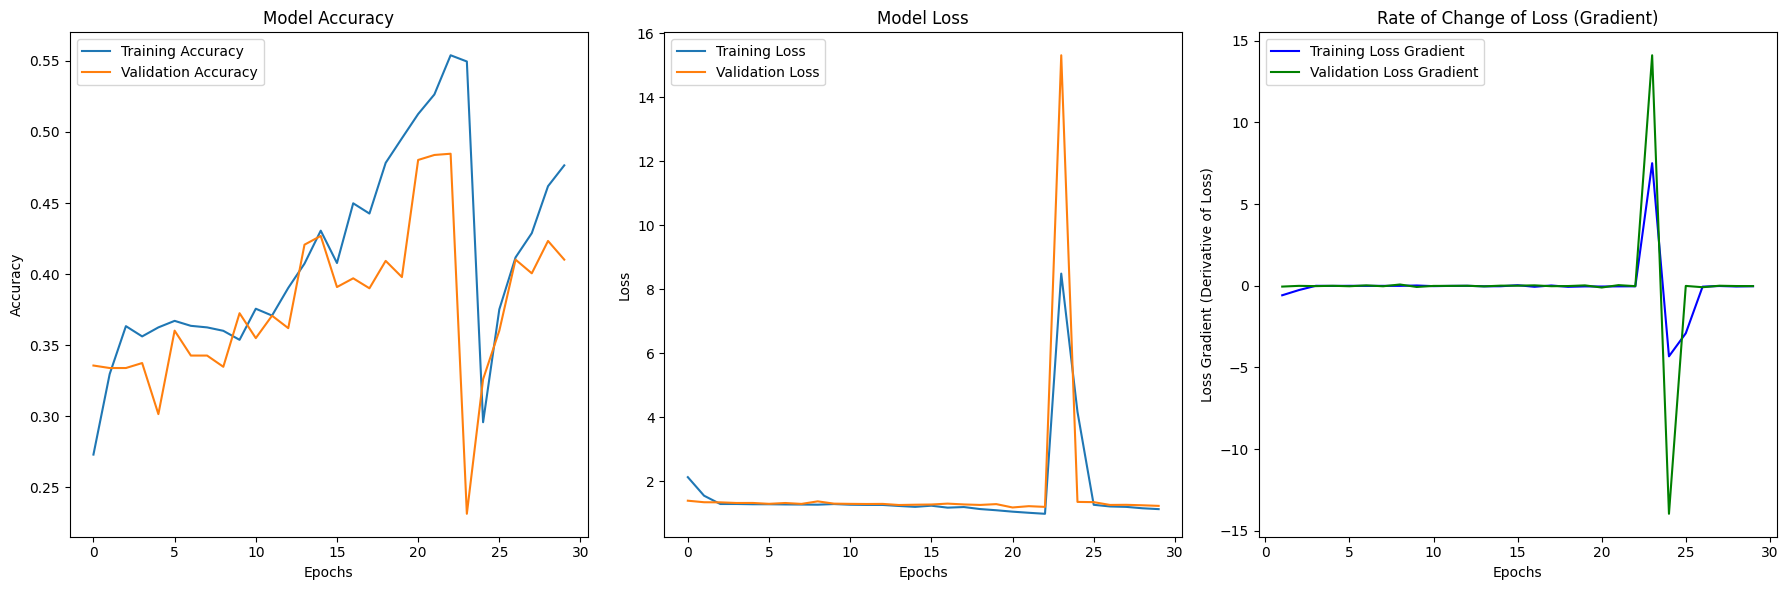

In [ ]:
def plot_training_history(history):
    """
    Plots the training accuracy, validation accuracy, training loss,
    validation loss, and the rate of change of the training loss (gradient)
    over epochs.

    Parameters:
    - history: The history object returned by model.fit(), which contains
               accuracy, loss, and other metrics over the epochs.
    """
    # Extract accuracy and loss data from history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the learning rates (if you have used a learning rate scheduler)
    learning_rate = history.history.get('lr', [0.001] * len(train_loss))  # Default to 0.001 if not available

    # Calculate the rate of change (gradient) of the loss
    train_loss_gradients = [train_loss[i] - train_loss[i-1] for i in range(1, len(train_loss))]
    val_loss_gradients = [val_loss[i] - val_loss[i-1] for i in range(1, len(val_loss))]

    # Plot the Accuracy, Loss, and Loss Gradient
    plt.figure(figsize=(18, 6))

    # Accuracy plot
    plt.subplot(1, 3, 1)  # Create a subplot (1 row, 3 columns, 1st plot)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 3, 2)  # Create a subplot (1 row, 3 columns, 2nd plot)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Loss Gradient plot
    plt.subplot(1, 3, 3)  # Create a subplot (1 row, 3 columns, 3rd plot)
    plt.plot(range(1, len(train_loss_gradients) + 1), train_loss_gradients, label='Training Loss Gradient', color='b')
    plt.plot(range(1, len(val_loss_gradients) + 1), val_loss_gradients, label='Validation Loss Gradient', color='g')
    plt.title('Rate of Change of Loss (Gradient)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Gradient (Derivative of Loss)')
    plt.legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

plot_training_history(history)

The 3 plots above display how the model learned over time. the first plot displays model accuracy (the proportion of data correctly classified) over each epoch. As we see model accuracy increased over time which is what we expect as the model becomes more 'familar' with the data and tunes itself accordigly. Although the accuracy dropped significantly around 23 epochs (perhaps where the model unsuccesfully attempted to explore another area of the loss space).  Similarly, the central plot displays the loss function against epochs. As we see, the loss function for the training data reduced very slightly. We see that the validation data is less consistent and that the model validation accuracy and loss fluxuates more than the training loss. Intuitevly, this is expected since the validation data is used to test the model on unseen data which may contain data that the model has not yet encountered during training. Consequentally, the validation performance metrics fluxuate as the model hasn't fully generalised yet.

In order to visualise the performance metric for various models, we will need to create a new function that plots these values for multiple models.

In [ ]:
def plot_training_history_multiple_models(histories, labels=None):
    """
    Plots the training accuracy, validation accuracy, training loss,
    validation loss, and the rate of change of the training loss (gradient)
    over epochs for multiple models.

    Parameters:
    - histories: A list of history objects (one per model) returned by model.fit().
    - labels: Optional list of labels for each model, for legend purposes.
    """
    # Check if we have labels, if not, create generic labels
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(histories))]

    # Set up subplots
    plt.figure(figsize=(18, 10))

    # Iterate over all models and plot the training history
    for i, history in enumerate(histories):
        # Extract accuracy and loss data from history
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Get the learning rates (if you have used a learning rate scheduler)
        learning_rate = history.history.get('lr', [0.001] * len(train_loss))  # Default to 0.001 if not available

        # Calculate the rate of change (gradient) of the loss
        train_loss_gradients = [train_loss[j] - train_loss[j-1] for j in range(1, len(train_loss))]
        val_loss_gradients = [val_loss[j] - val_loss[j-1] for j in range(1, len(val_loss))]

        # Plot training accuracy (subplot 1)
        plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st plot
        plt.plot(train_accuracy, label=f'Training Accuracy ({labels[i]})')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot validation accuracy (subplot 2)
        plt.subplot(2, 3, 2)  # 2 rows, 3 columns, 2nd plot
        plt.plot(val_accuracy, label=f'Validation Accuracy ({labels[i]})')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training loss (subplot 3)
        plt.subplot(2, 3, 3)  # 2 rows, 3 columns, 3rd plot
        plt.plot(train_loss, label=f'Training Loss ({labels[i]})')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation loss (subplot 4)
        plt.subplot(2, 3, 4)  # 2 rows, 3 columns, 4th plot
        plt.plot(val_loss, label=f'Validation Loss ({labels[i]})')
        plt.title('Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


Now, we will directly change various hyperparameters in our model as assess how this impacts performance.

# 2.2.1 Epochs and Batch size

We will begin by change the number of epochs and the batch size in our model. Let us begin by defining these parameters.

An Epoch simply refer to a complete pass through the entire training dataset. In our initial model, we set the total number of epochs to 10. Essentially, in this section, we are hoping to find the optimal balance between our training time (which we want to reduce) and validation accuracy levels (which we want to increase). This balance is achieved when the accuracy plateaus, signaling that further training will not yield any significant validation accuracy improvements. Furthermore, too many epochs can lead to overfitting as the model begins to memorise the training data and too few epochs can lead to underfitting where the model has not yet had sufficient time to learn the data [8].

batch size refers to the number of training rows that the model intakes before updating it's weights. In our case, the default value for batch size is 32. In our image classification problem, this would be the model would consider 32 images before making any weight adjustments.

Due to time-constraints, we will first begin our epoch investigation by considering training the same base model over 10, 20, 30, 40 and 50 epochs to assess how performance is impacted with the addition of more epochs. Ideally, we would prefer to test the model on more than this but given GPU limitations on colab, this will have to suffice.

### Epochs



In [ ]:
history_of_models_epochs = []
epoch_counts = [10,20,30,40,50]
for epochs in epoch_counts:
  print(f'Epochs: {epochs}')
  base_model = create_vgg16_swish_model()
  history = base_model.fit(train_generator,  # Generator for training data
    epochs=epochs,        # Number of epochs
    validation_data=validation_generator)  # Generator for validation data), callbacks=[early_stopping])
  history_of_models_epochs.append(history)
  print('')

Epochs: 10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.2464 - loss: 1.5005 - val_accuracy: 0.2314 - val_loss: 1.6899
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.3369 - loss: 1.3899 - val_accuracy: 0.2787 - val_loss: 1.4190
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.3274 - loss: 1.3369 - val_accuracy: 0.3567 - val_loss: 1.3057
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.3543 - loss: 1.3126 - val_accuracy: 0.3628 - val_loss: 1.3251
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.3628 - loss: 1.2897 - val_accuracy: 0.3611 - val_loss: 1.3267
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.3701 - loss: 1.2798 - val_accuracy: 0.3453 - val_loss: 1.3174
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.3950 - loss: 1.2744 - val_accuracy: 0.3777 - val_loss: 1.2950
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.3665 - loss: 1.2831 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.2686 - loss: 1.3917 - val_accuracy: 0.2796 - val_loss: 1.3833
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.2817 - loss: 1.3847 - val_accuracy: 0.2796 - val_loss: 1.3848
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.2811 - loss: 6.8452 - val_accuracy: 0.2796 - val_loss: 2.0784
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.3162 - loss: 1.3984 - val_accuracy: 0.3471 - val_loss: 1.3240
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.3709 - loss: 1.2947 - val_accuracy: 0.3699 - val_loss: 1.2981
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.3782 - loss: 1.2660 - val_accuracy: 0.3392 - val_loss: 1.3260
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.3718 - loss: 1.2811 - val_accuracy: 0.3628 - val_loss: 1.3133
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.3749 - loss: 1

KeyboardInterrupt: 

# Comparing Epoch Performances

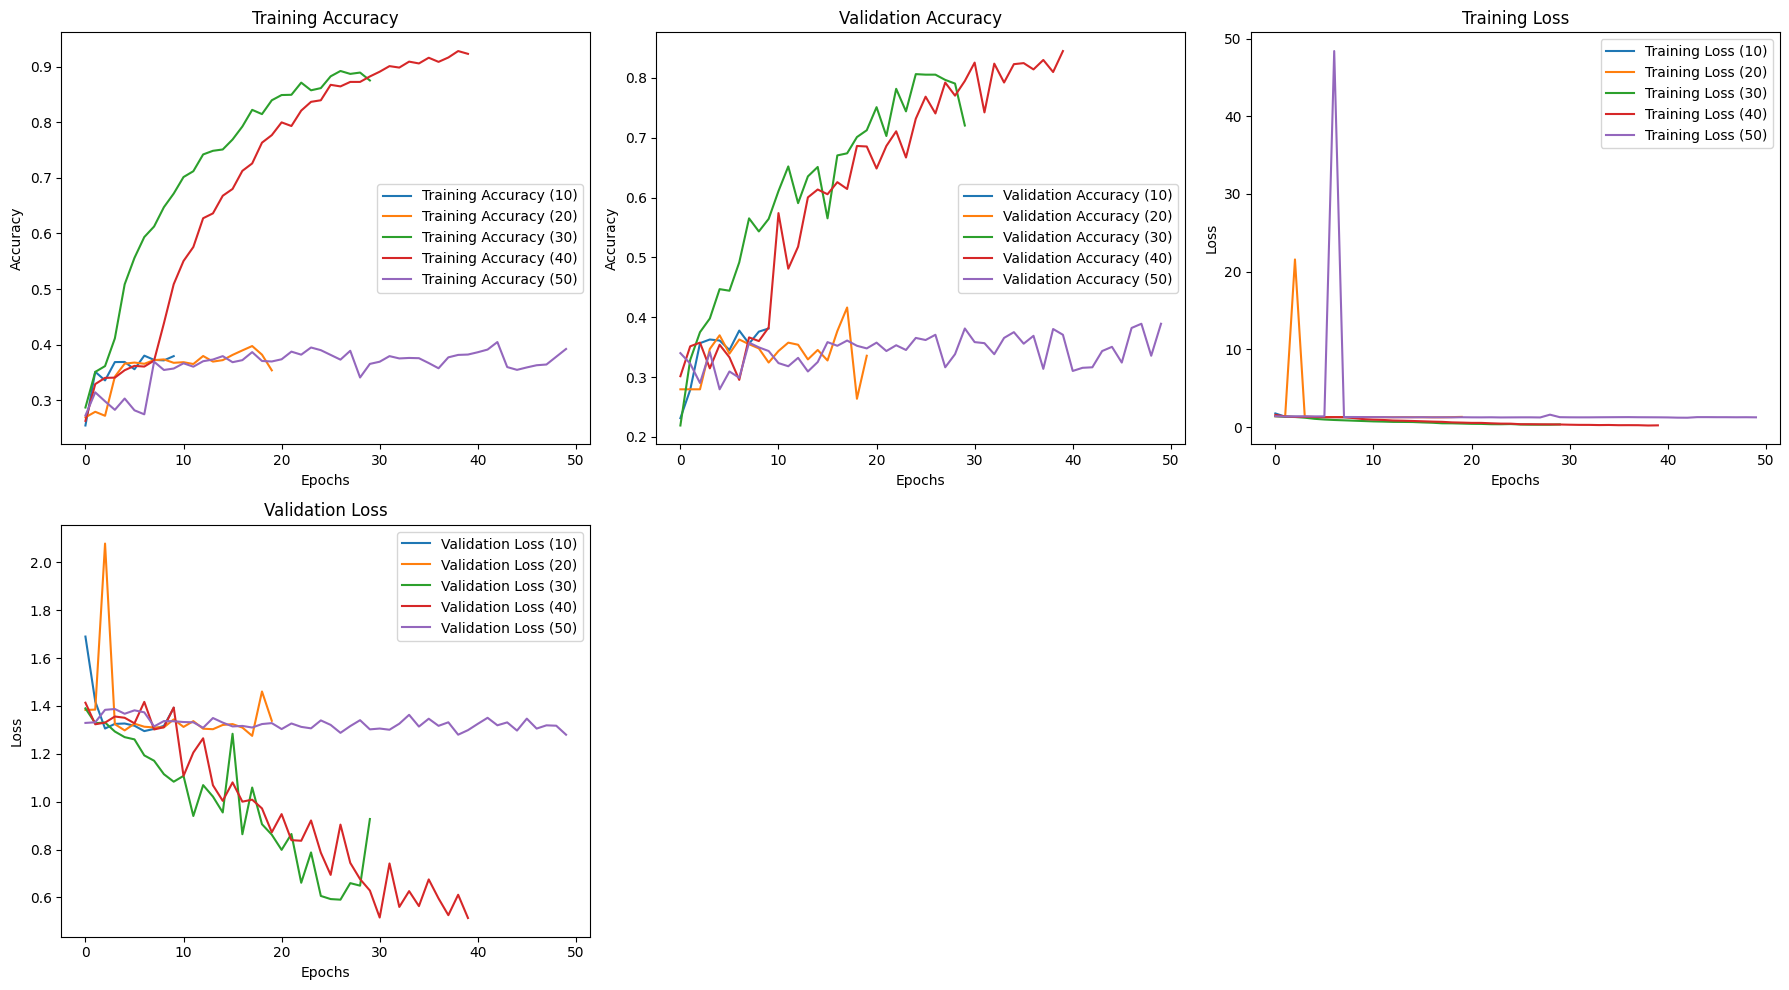

In [ ]:
plot_training_history_multiple_models(history_of_models_epochs, epoch_counts)

Here, we see the best performing model was when we ran the model with 40 epochs.We see that in the case of the 10-epoch model, metrics only marginally improved with the model ending on a validation accuracy of 0.3812. This suggests that perhaps the model was not given sufficient time to generalise to unseen validation data. We saw a much improved performance from the models with more epochs which managed to reach much higher validation accuracy scores. Strangely, when we increased the epochs further (see either our initial base model that ran over 50-epoch model), the performance worsened and particularly in the case of our 50-epoch model, returned to performance levels similar to that of the 10-epoch model. This could be due to a multitude of reasons. For example, the model could be overfitting where the model is essentially memorising the training data however the relatively poor performance on the training data suggest otherwise. Whatever the case, this result is somewhat reassuring for us as fewer epochs speeds up the run-time. Given that the purpose of this investigation is not solely to establish an optimal model and as we will be having to train several models for every hyperparameter we attempt to investigate, we will choose to run our models with 25 epochs as a means of attempting to satisfy this tradeoff between run-time and performance.

In [ ]:
epoch_count = 25

### Batch Size

In [ ]:
batch_sizes = [8,16,32,64,128]
history_of_models_batches = []
for batch_size in batch_sizes:
  print('Batch Size: ',batch_size)
  model = create_vgg16_swish_model()
  history = model.fit(train_generator,epochs=epoch_count,validation_data=validation_generator,batch_size=batch_size)
  history_of_models_batches.append(history)
  print('')

Batch Size:  8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - accuracy: 0.2612 - loss: 1.4411 - val_accuracy: 0.2340 - val_loss: 1.4363
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.3213 - loss: 1.3518 - val_accuracy: 0.3111 - val_loss: 1.3744
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.3443 - loss: 1.3611 - val_accuracy: 0.2340 - val_loss: 1.3890
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.2618 - loss: 1.3852 - val_accuracy: 0.2796 - val_loss: 1.3836
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.2665 - loss: 1.3850 - val_accuracy: 0.2796 - val_loss: 1.3840
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.2915 - loss: 1.3760 - val_accuracy: 0.2796 - val_loss: 1.3755
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.3019 - loss: 1.3551 - val_accuracy: 0.3111 - val_loss: 1.3359
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.3773 - loss: 1.2874 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.2631 - loss: 1.4091 - val_accuracy: 0.2743 - val_loss: 1.3822
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.2882 - loss: 1.3700 - val_accuracy: 0.2796 - val_loss: 1.3836
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.2845 - loss: 1.3832 - val_accuracy: 0.2796 - val_loss: 1.3803
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.2792 - loss: 1.3810 - val_accuracy: 0.2796 - val_loss: 1.3835
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.2721 - loss: 2.3665 - val_accuracy: 0.2550 - val_loss: 9.2159
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.2758 - loss: 11.3943 - val_accuracy: 0.3295 - val_loss: 1.3563
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3660 - loss: 1.2965 - val_accuracy: 0.3488 - val_loss: 1.3294
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.3420 - loss: 

# Comparing batch size performances

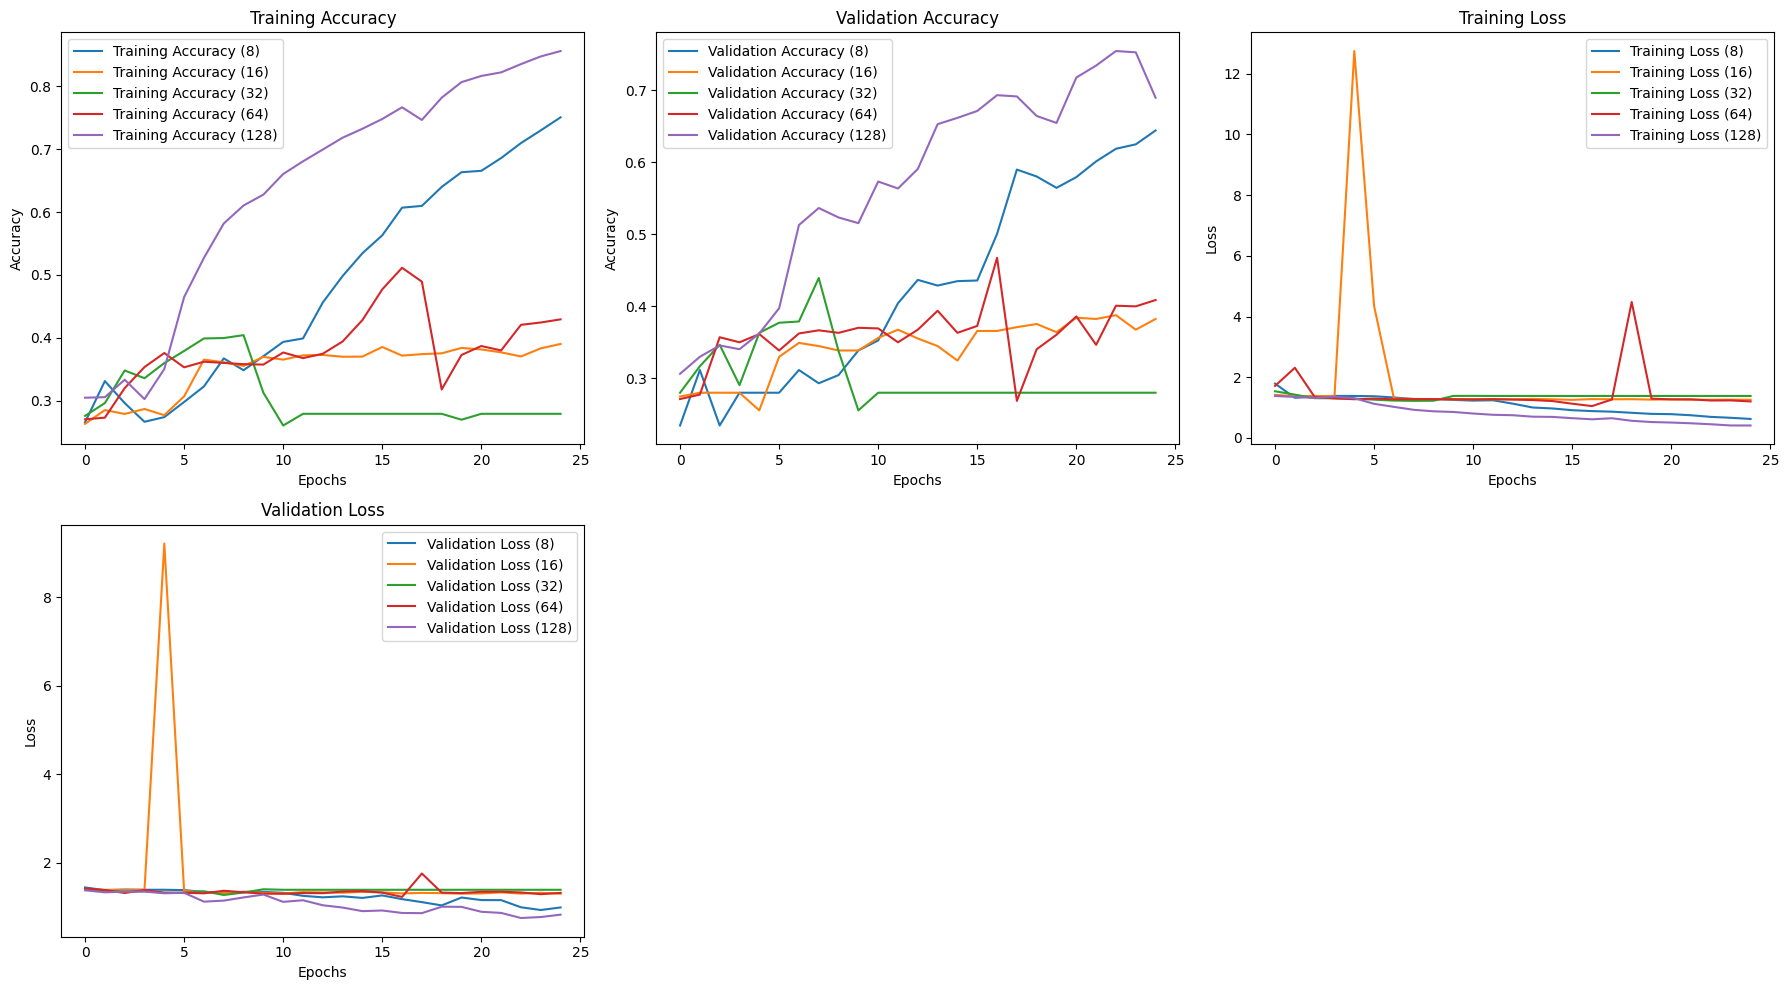

In [ ]:
plot_training_history_multiple_models(history_of_models_batches, batch_sizes)

As we see the model with the highest validation and training accuracy was the model implimented with a batch size of 128 with a validation accuracy of 72% whilst the model implimented with a batch size of 8 came in second with a validation accuracy of roughly 64%. It is intersting to see that these two batch sizes resulted in the best performance since these were the smallest and largest batch sizes we considered. One may have expected the small batch model to perform the best since smaller batch sizes result in more frequent updates to the model's parameters per epoch, helping the model to learn the patterns in the data better. The main advantage of larger batch sizes is that epoch completion occurs at a faster rate since there are fewer updates per epoch. It is therefore interesting to see that the model performed the best under a batch size of 128...

# 2.2.2 Learning Rate

In this section, we will modify and attempt to find an optimal value for our learning rate. In our baseline model, we used a static learning rate with value of 0.001 with an ADAM optimizer. We explore the details of stochastic gradient descent and implementations that use an adaptive learning rate in our section on the [ReLU activation function](https://github.com/vivekp12/dst-group-project-2/blob/main/VivekP/04-ReLUInvestigation.ipynb). As mentioned, the implementation of a dynamic learning rate enables a better tradeoff between exploration and exploitation, facilitating convergence to (at least) a local minimum loss. A large static learning rate can accelerate the model's exploration of the loss landscape, potentially speeding up training. However, it may cause the model to overshoot or skip over optimal minima and lead to divergent behaviour [9][10]. On the other hand, a small static learning rate reduces the model exploration, leading to more gradual updates. While this means the model may require more epochs to fully converge and reach optimal performance, it allows for more accurate convergence on a minimum, as it makes smaller, more precise adjustments to the parameters.![Learning Rate Example](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png). We will consider various different dynamic learning rate algorithms, comparing their methodology and then establish which of them leads to the highest performance. Below, we list the various methods we will impliment to experiment with different learning rate scheduling techniques alongside a static learning rate model which will act as a sort of control test.

## Warm Restarts

Warm restarts refers to the periodic resetting of the learning rate following a phase of decay, the theory behind this being that the re-raising of the learning rate allows the model to jump out of flat or undesirable regions in the loss surface, working to escape any local minima in an attempt to find a global minima therefore potentially leading to improved accuracy scores. Review of various literature published on warm restarts has suggested that in the application domain of image classification, implimenting warm restarts with cosine annealing [11] or with a polynomial learning rate [12] can lead to improved results compared to models that impliment learning rates with step-wise decay. The original paper published by Loshchilov & Hutter [11] performed warm restart models on various image classification datasets such as ImageNet [13] as well CIFAR-10 and CIFAR-100 [14]. The conclusion of this paper suggested that implimentation of warm restarts worked to speed up convergence by a factor of two to four as this helped to escape poor local minima and flat regions of the loss surface. Additionally, whilst warm restarts were initially applied to the Stochastic Gradient Descent activation function (SGD), the authors suggest that future work should consider warm restarts for other popular training algorithms such as AdaDelta and namely, Adam, the activation function we impliment in this project. Furthermore, by resetting the learning rate, the classical problem of selecting an optimal learning rate is addressed as the model can explore different ranges during training as opposed to following a monotonically decreasing function [15]. A paper published by the
Indian Institute of Technology [12] has suggested that implimentation of polynomial decay learning rate with a single warm restart can obtain better classification accuracy as well as facilitating faster optimization on CIFAR and imagenet.

We will impliment the following Learning rate schedulers in our analysis:


### 1. Exponential Decay

Exponential Decay is a method of iteratively annealing the learning rate over time (i.e. per epoch or per batch) from an initial large value which allows for faster convergence on a minimum training loss and then as training progresses, the value of the learning rate is reduced by a fixed factor to prevent stepping over the minimum and thus allowing for a precice convergence. The rate of decay is defined:

### 2. ReduceLROnPlateau

ReduceLROnPlateau works by following a metric (e.g. validation loss) and updates the learning rate when this metric plateaus. This method is helpful when the model has "stagnated" during training and you want to encourage it to find better local minima by taking smaller steps. For example, consider the right plot in the above diagram which steps over the minimum. Essentially, the model can take large steps if they are resulting in a reduction in terms of loss but when progress stalls and the loss plateaus, the learning rate can adjust itself. Hence, this allows for fast exploration when progress is being made and prevents overshooting the optimal solution.

### 3. Cosine Annealing w/ warm restarts [11][16]

Cosine annealing operates similarly to exponential decay however instead of decaying according to an exponential function, the annealing process follows a cosine function. See below for a more in-depth description.

### 4. Polynomial Learning Rate w/ warm restarts [12][17]

Similarly to Cosine and Exponential Decay, this process involves the decaying of the learning rate as we attempt to hone in on a minima.

### 5. Static Learning Rate

As aforementioned, we will impliment 2 models with static learning rates to show how the dynamic learning rate models fair against models that are not configured specifically to converge on a minimum by adjusting their learning rate decromentally over time. For one, our base model is designed with a small static learning rate of 0.001. We will also impliment a model with a large static learning rate. This means that the 'steps' that the model makes along the loss function are larger allowing for greater exploration of the loss space but makes convergence more difficult. This model will have a learning rate of 0.1. Comparing the two static models, this means that in practice, the updating of the weights operates as follows:

$$w_{t+1} = w_t - \eta \cdot \nabla L(w_t)$$

where

- $ w_t $: The weights or parameters of the model at step $ t $.
- $ \nabla L(w_t) $: The gradient of the loss function $ L(w) $ with respect to the weights $ w_t $.
- $ \eta $: The learning rate
- $ w_{t+1} $: The updated weights after applying the gradient step.







In [ ]:
def print_lr(epoch, logs):
    lr = current_model.optimizer.learning_rate
    print('')
    print(f"Epoch {epoch+1}: Learning rate is {lr.numpy()}")

# Create a custom callback to print the learning rate
display_lr = tf.keras.callbacks.LambdaCallback(on_epoch_end=print_lr)

epoch_count = 25
batch_size = 32
initial_learning_rate = 0.001

# Exponential decay implimentation

here, you want to talk about choice of decay steps, decay rate and initial learning rate.

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=500,  # Decay over the entire training process
    decay_rate=0.96,          # Reduce by 4% every decay step
    staircase=True            # Decay in discrete steps (instead of continuously)
)
exp_lr_model = create_vgg16_swish_model(lr_scheduler=lr_scheduler)
current_model = exp_lr_model
history_exp = exp_lr_model.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator,
                    callbacks=[display_lr], batch_size = batch_size)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2748 - loss: 1.4781
Epoch 1: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.2748 - loss: 1.4845 - val_accuracy: 0.2796 - val_loss: 1.8100
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2901 - loss: 1.7651
Epoch 2: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.2903 - loss: 1.7630 - val_accuracy: 0.3401 - val_loss: 1.3327
Epoch 3/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3593 - loss: 1.2945
Epoch 3: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.3593 - loss: 1.2943 - val_accuracy: 0.3401 - val_loss: 1.3111
Epoch 4/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3515 - loss: 1.2750
Epoch 4: Learning rate is 0.0009600000339560211
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.3516 - loss: 1.2750 - val_accuracy: 0.303

# ReduceLROnPlateau implimentation

Currently, TensorFlow does not provide a direct learning rate schedule within the tf.keras.optimizers.schedules module (like ExponentialDecay). The ReduceLROnPlateau callback is the primary method for achieving this LR behavior. Learning rate schedules are predefined rules for adjusting the learning rate over time based on the number of steps or epochs. This method
doesn't follow a regular time-based schedule but reacts to metrics (like validation loss or accuracy) during training. It adapts the learning rate when a plateau in the performance metric is detected as opposed to adapting in fixed time intervals. In theory, this can lead to improved performance, as the learning rate is dynamically adjusted based on the model’s behavior, rather than following a predetermined schedule.

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor (e.g., validation loss)
    factor=0.5,                # Factor by which to reduce the learning rate
    patience=3,               # Number of epochs with no improvement after which learning rate is reduced
    min_lr=1e-6,               # Minimum learning rate, it won't go lower than this value
    verbose=0
)

RLOP_model = create_vgg16_swish_model()
history_rlop = RLOP_model.fit(train_generator,
          epochs=epoch_count,
          validation_data=validation_generator,
          callbacks=[lr_scheduler, display_lr],  # Add the scheduler as a callback
          verbose=1)

Epoch 1/25
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2570 - loss: 1.4032
Epoch 1: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.2572 - loss: 1.4029 - val_accuracy: 0.2796 - val_loss: 1.3834 - learning_rate: 0.0010
Epoch 2/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2765 - loss: 1.5433
Epoch 2: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.2764 - loss: 1.5584 - val_accuracy: 0.2796 - val_loss: 12.9636 - learning_rate: 0.0010
Epoch 3/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3129 - loss: 1.9594
Epoch 3: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.3132 - loss: 1.9525 - val_accuracy: 0.2918 - val_loss: 1.3832 - learning_rate: 0.0010
Epoch 4/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3442 - loss: 1.3156
Epoch 4: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━

# Cosine Decay w/ warm restarts implimentation

In this section, we'll impliment cosine decay with and without warm restarts. This way, not only can we compare its performance with the other learning rate schedulers but also assess how impactful warm restarts is in terms of model performance and optimisation efficiency. This method of Cosine Annealing reduces the learning rate following a cosine function over a predefined number of epochs. Similar to exponential decay, the learning rate starts larger and is reduced according to the cosine function. Mathematically, the learning rate calculation occurs as follows [18]:

$
\eta(t) = \eta_{\min} + \frac{1}{2} (\eta_{\max} - \eta_{\min}) \left( 1 + \cos \left( \frac{t * \pi}{T_{\text{max}}} \right) \right)
$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate,
- $T_{\text{max}}$ is the total number of iterations or epochs,
- $t$ is the current step or iteration.

Please see Appendix A for a visual guide to cosine annealing  [19].

The formula for cosine annealing with warm restarts can be written as [11]:

$$
\eta(t) = \eta_{\min} + \frac{1}{2} (\eta_{\max} - \eta_{\min}) \left( 1 + \cos \left( \frac{T_{\text{cur}}}{T_i} \pi \right) \right)
$$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate,
- $T_{\text{cur}}$ is the current iteration or time step since the last restart,
- $T_i$ is the total number of epochs in that cycle.

The formula given applies to a single cycle in the process of annealing where the $i$-th cycle corresponds to the $i$-th restart of the learning rate.
Essentially, After $T_i$ epochs, the learning rate is reset to its maximum value and then follows the cosine annealing decay for the next $T_{i+1}$ epochs.

  









## Without Warm Restarts

In [ ]:
decay_steps = epoch_count*50  # Number of steps for the learning rate to decay

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    name='CosineDecay'
)

# Create and compile the model
cos_model = create_vgg16_swish_model(lr_scheduler=lr_scheduler)

# Train the model
history_cos = cos_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr] ) # Assuming display_lr is your learning rate display callback

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2761 - loss: 1.4963
Epoch 1: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.2761 - loss: 1.4979 - val_accuracy: 0.2436 - val_loss: 1.4557
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3394 - loss: 1.3243
Epoch 2: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.3394 - loss: 1.3241 - val_accuracy: 0.3278 - val_loss: 1.3457
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3636 - loss: 1.2751
Epoch 3: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.3636 - loss: 1.2751 - val_accuracy: 0.3944 - val_loss: 1.2918
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3816 - loss: 1.2660
Epoch 4: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.3816 - loss: 1.2660 - val_accuracy: 0.358

## With Warm Restarts

In [ ]:
first_decay_steps = batch_size*epoch_count  # Number of steps for the first restart (typically corresponds to your batch size * epochs)

lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps,
)
# Create and compile the model
cosr_model = create_vgg16_swish_model(lr_scheduler=lr_scheduler)

# Train the model
history_cosr = cos_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4240 - loss: 1.1948
Epoch 1: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.4239 - loss: 1.1948 - val_accuracy: 0.4023 - val_loss: 1.2812
Epoch 2/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4319 - loss: 1.1980
Epoch 2: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.4319 - loss: 1.1979 - val_accuracy: 0.3804 - val_loss: 1.2870
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4438 - loss: 1.1846
Epoch 3: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.4437 - loss: 1.1847 - val_accuracy: 0.4067 - val_loss: 1.3015
Epoch 4/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4233 - loss: 1.2016
Epoch 4: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.4233 - loss: 1.2015 - val_accuracy: 0.4093

# Polynomial Decay w/ warm restarts

We also impliment polynomial decay with and without warm restarts.

The polynomial learning rate decay formula is given by:

$$
\eta(t) = \eta_{\min} + (\eta_{\max} - \eta_{\min}) \left( 1 - \frac{t}{T} \right)^p
$$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate,
- $t$ is the current epoch,
- $T$ is the total number of epochs over which the learning rate decays,
- $p$ is the polynomial power controlling the decay rate. According to [12], a power of 0.9 has proved the most succeful in terms of model accuracy and optimisation speed when tested on the CIFAR-100 dataset.

The polynomial learning rate decay with warm restarts formula is given by:

$$
\eta(t) = \eta_{\min} + (\eta_{\max} - \eta_{\min}) \left( 1 - \frac{T_{\text{cur}}}{T_i} \right)^p
$$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate, which is reset after each warm restart,
- $T_{\text{cur}}$ is the current time step (or epoch) within the $i$-th cycle,
- $T_i$ is the total number of iterations (or epochs) in the $i$-th cycle (i.e., between two warm restarts),
- $p$ is the polynomial power controlling the decay rate,
- $i$ is the cycle index, representing the $i$-th warm restart.

After every $T_i$ epochs, the learning rate is reset to $\eta_{\max}$ and the polynomial decay starts again for the next cycle. Different implimentations allow for the decay to restart from a lower initial value than before (for example, instead of starting at the maximum, you start at a fraction of this value according to how far into the training you are). Furthermore, research [12] found that the best results occured with a single restart after 25% of the total number of epochs were completed although also stated that "A single learning rate policy may not be universally applicable
 to any DNN model or dataset".



## Without Warm Restarts

In [ ]:
end_learning_rate = 0.0001  # The final learning rate at the end of decay
power = 2  # Polynomial power, typically set to 1.0

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power,
)

# Create and compile the model
poly_model = create_vgg16_swish_model(lr_scheduler=lr_scheduler)

# Train the model
history_poly = poly_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr]
)


Epoch 1/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2701 - loss: 1.3886
Epoch 1: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.2703 - loss: 1.3887 - val_accuracy: 0.2585 - val_loss: 1.3869
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2812 - loss: 1.7751
Epoch 2: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.2813 - loss: 1.7745 - val_accuracy: 0.3269 - val_loss: 1.3536
Epoch 3/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3557 - loss: 1.2895
Epoch 3: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.3558 - loss: 1.2895 - val_accuracy: 0.3094 - val_loss: 1.3770
Epoch 4/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3564 - loss: 1.2881
Epoch 4: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.3565 - loss: 1.2880 - val_accuracy: 0.369

## With Warm Restarts

The implimentation of polynomial decay with warm restarts proved more difficult than previous implimentations and required us to impliment a class with attributes as defined below and a call function that would be responsible for updating the learning rate. The learning rate scheduler is then defined as an object of type PolyRestartSchedule and the model is trained with this scheduler.

In [ ]:
class PolyRestartSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate=0.001, decay_steps=1000, end_learning_rate=0.0001, power=2, t_mul=2.0):
        super(PolyRestartSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.end_learning_rate = end_learning_rate
        self.power = power
        self.t_mul = t_mul

    def __call__(self, epoch):
        # Ensures the epoch is cast to a float32 tensor for proper division
        epoch = tf.cast(epoch, tf.float32)

        # Determine the current cycle and steps in the cycle using TensorFlow operations
        cycle = tf.floor(epoch / self.decay_steps)
        current_step = epoch % self.decay_steps
        cycle_steps = self.decay_steps * (self.t_mul ** cycle)

        current_step = tf.cast(current_step, tf.float32)

        # Polynomial decay calculation
        decay_rate = 1 - (current_step / cycle_steps)
        learning_rate = self.end_learning_rate + (self.initial_learning_rate - self.end_learning_rate) * (decay_rate ** self.power)

        return learning_rate

lr_scheduler = PolyRestartSchedule(initial_learning_rate=0.001, decay_steps=500, end_learning_rate=0.0001, power=2, t_mul=2.0)

polyr_model = create_vgg16_swish_model(lr_scheduler=lr_scheduler)

# Train the model
history_polyr = polyr_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr]
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2822 - loss: 1.3874
Epoch 1: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.2823 - loss: 1.3874 - val_accuracy: 0.2796 - val_loss: 1.3836
Epoch 2/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2926 - loss: 1.3614
Epoch 2: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.2931 - loss: 1.3608 - val_accuracy: 0.3322 - val_loss: 1.3347
Epoch 3/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3745 - loss: 1.2530
Epoch 3: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.3746 - loss: 1.2531 - val_accuracy: 0.3576 - val_loss: 1.3171
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3772 - loss: 4.9561
Epoch 4: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.3769 - loss: 5.0084 - val_accuracy: 0.23

# Static Learning Rate Models

Below we impliment the static large learning rate model. Note once again that our initial base model operates as our static small learning rate model and will not be reimplimented here.

## Large Static Learning Rate implimentation

In [ ]:
large_static_model = create_vgg16_swish_model(initial_learning_rate=0.01)
history_largestat = large_static_model.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator, callbacks=[display_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2432 - loss: 25733.9316
Epoch 1: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.2433 - loss: 25517.7598 - val_accuracy: 0.2533 - val_loss: 1.4261
Epoch 2/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2803 - loss: 1.4052
Epoch 2: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.2807 - loss: 1.4048 - val_accuracy: 0.3322 - val_loss: 1.3437
Epoch 3/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3604 - loss: 1.2938
Epoch 3: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.3605 - loss: 1.2937 - val_accuracy: 0.3330 - val_loss: 1.3500
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3704 - loss: 1.2852
Epoch 4: Learning rate is 0.0007514473400078714
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.3703 - loss: 1.2853 - val_accurac

# Comparing Learning Rate Performances

We will now evaluate the performances of our algorithms to see which model performs the best in terms of our perfomance metric, accuracy. First, it is interesting to visualise how the learning rates change over time for all the models. Consider the following plot of all the learning rates as they change as training progresses.

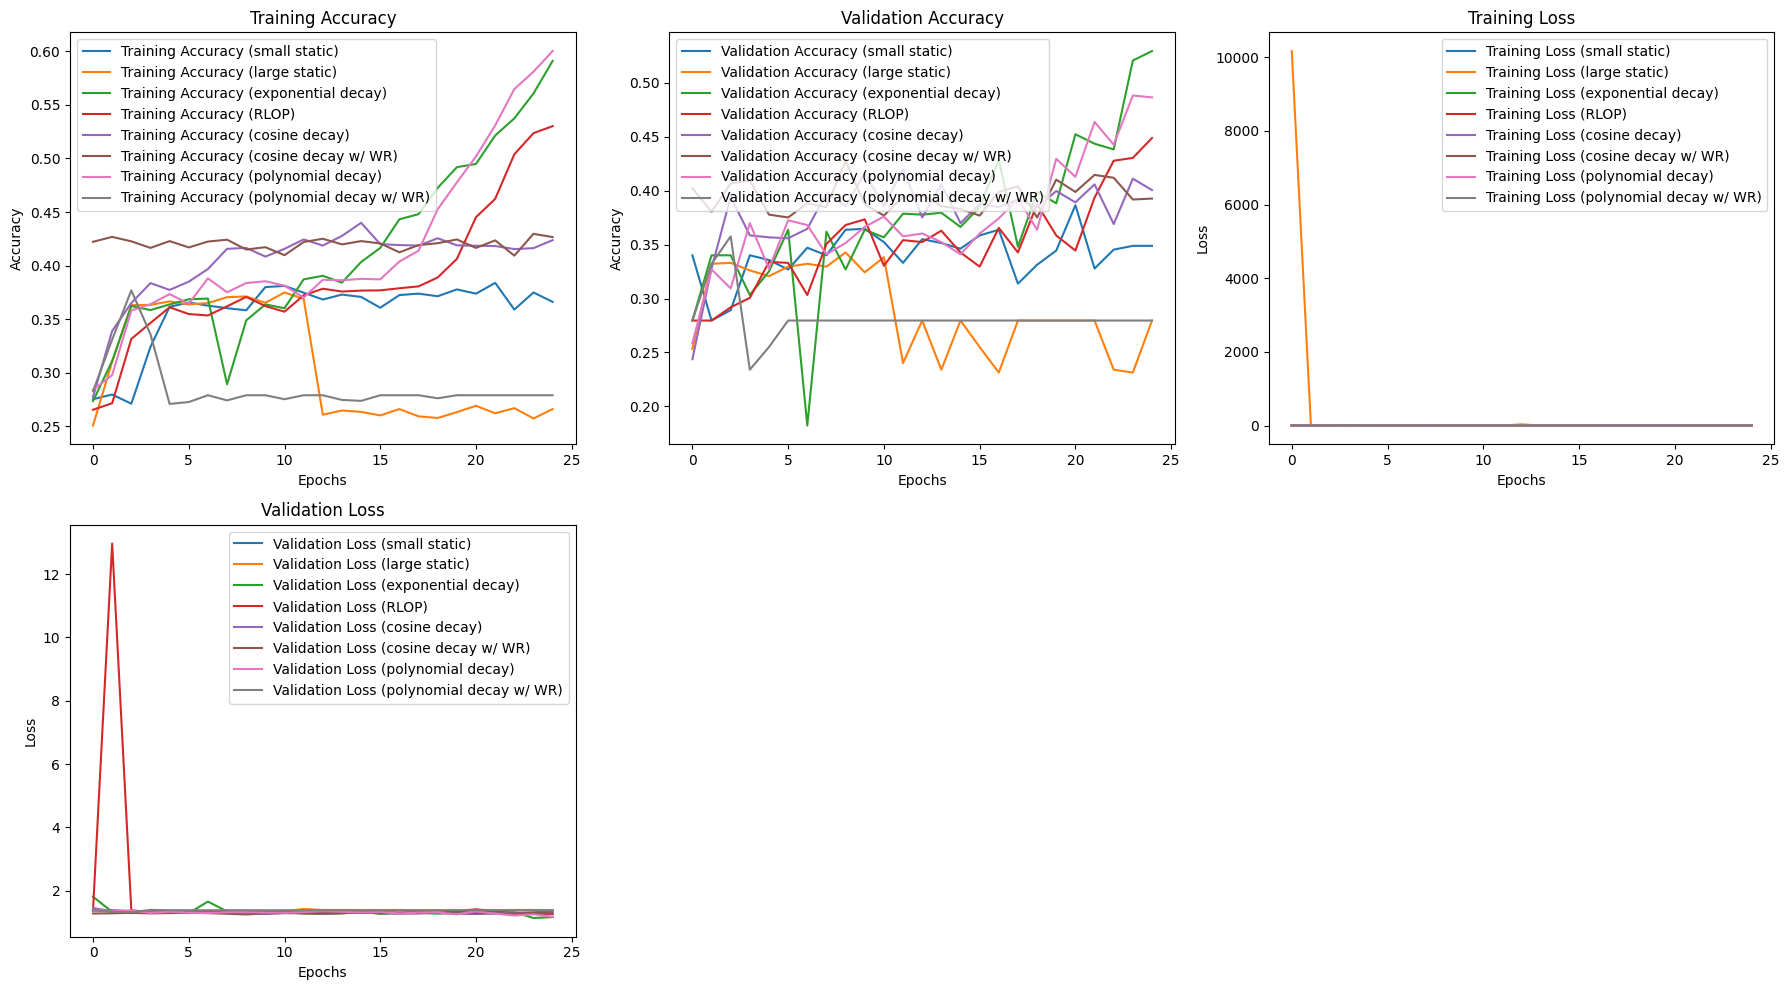

In [ ]:
all_results = [history, history_largestat, history_exp, history_rlop, history_cos, history_cosr, history_poly, history_polyr]
labels = ['small static','large static', 'exponential decay', 'RLOP', 'cosine decay', 'cosine decay w/ WR', 'polynomial decay', 'polynomial decay w/ WR']
plot_training_history_multiple_models(all_results, labels)

Clearly, due to some extreme cases, the validation loss and training loss plots are difficult to interpret. Unfortunately, due to colabs limitations on GPU usage, the runtime expired before we could rerun these plots to account for the extreme cases. Fortunately, the quantative values have been displayed above and the accuracy plots have been appropriately displayed.

From the visual it appears that the highest performing models were exponential decay, polynomial decay and RLOP with exponential decay and polynomial decay having the highest validation accuracy over the 25 epochs. Additionally we see that the worst performing models were the 2 static models as well as the polynomial decay with warm restarts. As aforementioned, it may make intuitive sense that the static models performed the worse as they struggle to converge on a minima.

# 2.2.3 Swish's scalable parameter, $ α $.

In this section of our experiment. We are going to evaluate the performance of our base model whilst adapting Swish's learning parameter previously defined as $ \alpha $. As we saw earlier, the standard swish function defines $ \alpha = 1 $ and tends to a linear function as this parameter tends to 0 whilst becoming more and more ReLU-like as we increases $\alpha$. This value works to alter the flow of gradients as the scale of the parameter controls how fast the first derivative asymptotes to 0 and 1 [3]. We can see from our original swish plot, the non-monotonic “bump” of the swish function at small negative values of $x$.
This can be important when controlling how easy it is for the model to escape local minima during optimisation. Sources such as Google's paper, *searching for activation functions* [3] or independent researcher, Eric Alcaide's paper, *E-swish: Adjusting Activations to Different Network Depths* [18] have suggested that changing this parameter can have an important impact on model performance and optimisation speeds. Additionally, as will be seen by the below plots of Swish and its gradient curves for varying values of $ \alpha $, for certain values of this parameter, the gradient can become greater than 1 potentially leading to gradient exploding problems during backpropogation which is particularly problematic in deep architectures as the gradients are iteratively multiplied which can lead to very large weights that cause the loss to blow up. Similalarly, when this learnable parameter is said to a small positive value, the derivative function outputs smaller values and can lead to gradient vanishing problems in deep networks meaning the model performance barely improves over epochs as weights (particularly in early layers) barely change. Therefore, in either case, model performance is impacted. For this reason, the default parameter sets this value to 1 as it tends to provide a balance between model performance, computation time and does well in avoiding some of these aforementioned potential issues.



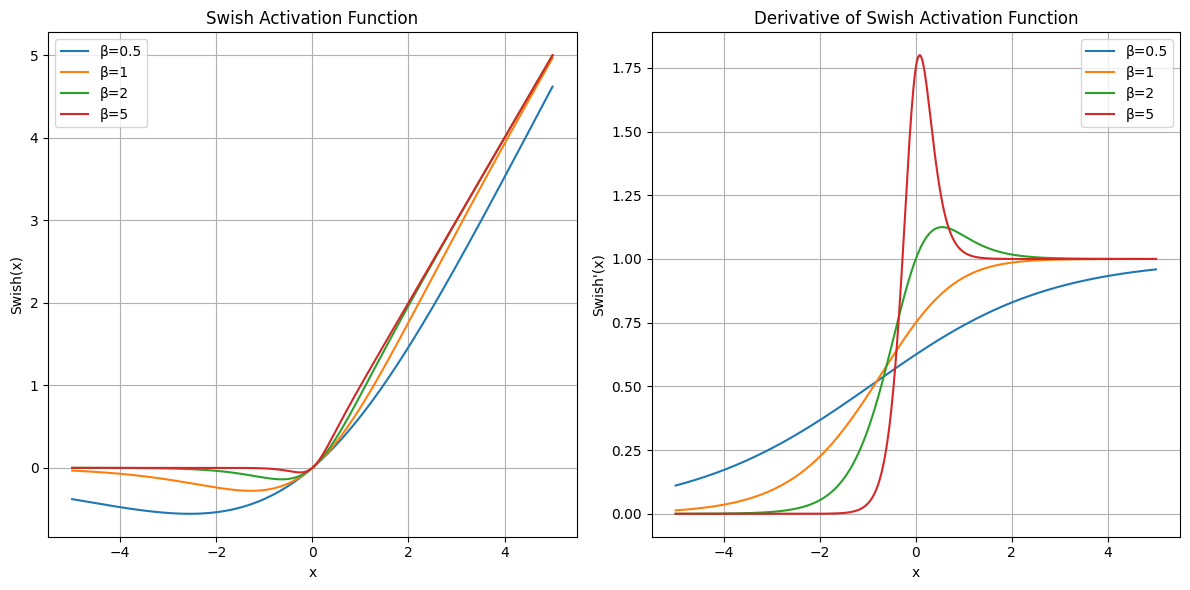

In [ ]:
# Define the derivative of Swish
def swish_derivative(x, beta):
    sigmoid = 1 / (1 + np.exp(-beta * x))
    return beta * sigmoid * (1 - sigmoid) + sigmoid

# Generate input values
x = np.linspace(-5, 5, 500)

# Define beta values to test
beta_values = [0.5, 1, 2, 5]

# Plot Swish functions and their derivatives
plt.figure(figsize=(12, 6))

# Swish Activation Plot
plt.subplot(1, 2, 1)
for beta in beta_values:
    y = swish_fun(x, beta)
    plt.plot(x, y, label=f"β={beta}")
plt.title("Swish Activation Function")
plt.xlabel("x")
plt.ylabel("Swish(x)")
plt.legend()
plt.grid()

# Swish Derivative Plot
plt.subplot(1, 2, 2)
for beta in beta_values:
    dy = swish_derivative(x, beta)
    plt.plot(x, dy, label=f"β={beta}")
plt.title("Derivative of Swish Activation Function")
plt.xlabel("x")
plt.ylabel("Swish'(x)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


We will structure this section of the investigation as follows

 1. Fixed $\alpha$ investigation
     - Here, we will compare the model performance in terms of convergence speed, training loss, and validation performance for various fixed values of $\alpha$.

2. Dynamic $ \alpha $ investigation
    - Here, we will impliment swish with a custom trainable tensorflow variable to investigate whether we can adapt and tailor the activation function to different stages of training.

In our previous base model, we did not have the option to adapt our swish parameter so we adjust the function such that this can be implimented.

In [ ]:
# Define the learnable swish activation function
def manipulate_swish(x, alpha):
    return x * tf.nn.sigmoid(alpha * x)

# Create the VGG16-like model with learnable swish
def create_vgg16_swish_model(input_shape=(64, 64, 3), num_classes=4, initial_learning_rate=0.001, lr_scheduler=None, swish_alpha=1, swish_learnable=False):
    model = models.Sequential()

    # Define alpha as a tf.Variable if learnable
    if swish_learnable:
        alpha = tf.Variable(initial_value=swish_alpha, trainable=True, dtype=tf.float32)
    else:
        alpha = swish_alpha  # Use the constant value of alpha if not learnable

    # Block 1: 2 Conv layers with 64 filters and Swish activation
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: 2 Conv layers with 128 filters and Swish activation
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: 2 Conv layers with 256 filters and Swish activation
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 5: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from the last convolutional block
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(256))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Dense(256))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax

    # Compile the model with the chosen learning rate and scheduler
    if lr_scheduler:
        model.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model



# 1. Fixed $\alpha$ investigation

Below we train various models with different values of the swish parameter.

In [ ]:
# Define different beta values for investigation
alpha_values = [0.5, 1.0, 1.5, 2.0]

static_alpha_results = []
for alpha in alpha_values:
    print(f"\nTraining with alpha = {alpha}")
    print()
    model = create_vgg16_swish_model(swish_alpha=alpha)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=25,
        callbacks=[]
    )

    # Store results for analysis
    static_alpha_results.append(history)



Training with alpha = 0.5



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.2734 - loss: 1.4288 - val_accuracy: 0.2550 - val_loss: 1.3852
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - accuracy: 0.2962 - loss: 1.3611 - val_accuracy: 0.2980 - val_loss: 1.3680
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.2644 - loss: 1.3842 - val_accuracy: 0.2796 - val_loss: 1.3823
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.2755 - loss: 3.0576 - val_accuracy: 0.2331 - val_loss: 20.0871
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.2854 - loss: 109.0379 - val_accuracy: 0.3558 - val_loss: 1.3219
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.3317 - loss: 1.3152 - val_accuracy: 0.3330 - val_loss: 1.3254
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.3498 - loss: 1.3034 - val_accuracy: 0.3225 - val_loss: 1.3543
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.3394 - loss

# 2. Dynamic $\alpha$ investigation

In this section, as aforementioned, we impliment a dynamic parameter that can adapt as training progresses.

In [ ]:
model_learnable_swish = create_vgg16_swish_model(swish_learnable=True)
history_learnable = model_learnable_swish.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.2782 - loss: 1.3958 - val_accuracy: 0.2585 - val_loss: 1.3856
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.2898 - loss: 1.3936 - val_accuracy: 0.3304 - val_loss: 1.3455
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.2759 - loss: 1.3798 - val_accuracy: 0.2796 - val_loss: 1.3842
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.2912 - loss: 1.3841 - val_accuracy: 0.3164 - val_loss: 1.3547
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.3468 - loss: 2.2584 - val_accuracy: 0.2594 - val_loss: 1.5233
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.2709 - loss: 1.4620 - val_accuracy: 0.3260 - val_loss: 1.3297
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.3637 - loss: 1.3135 - val_accuracy: 0.3479 - val_loss: 1.3043
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.3643 - loss: 1

# Comparing $ \alpha $ Performances

We will now visualise performances as before.

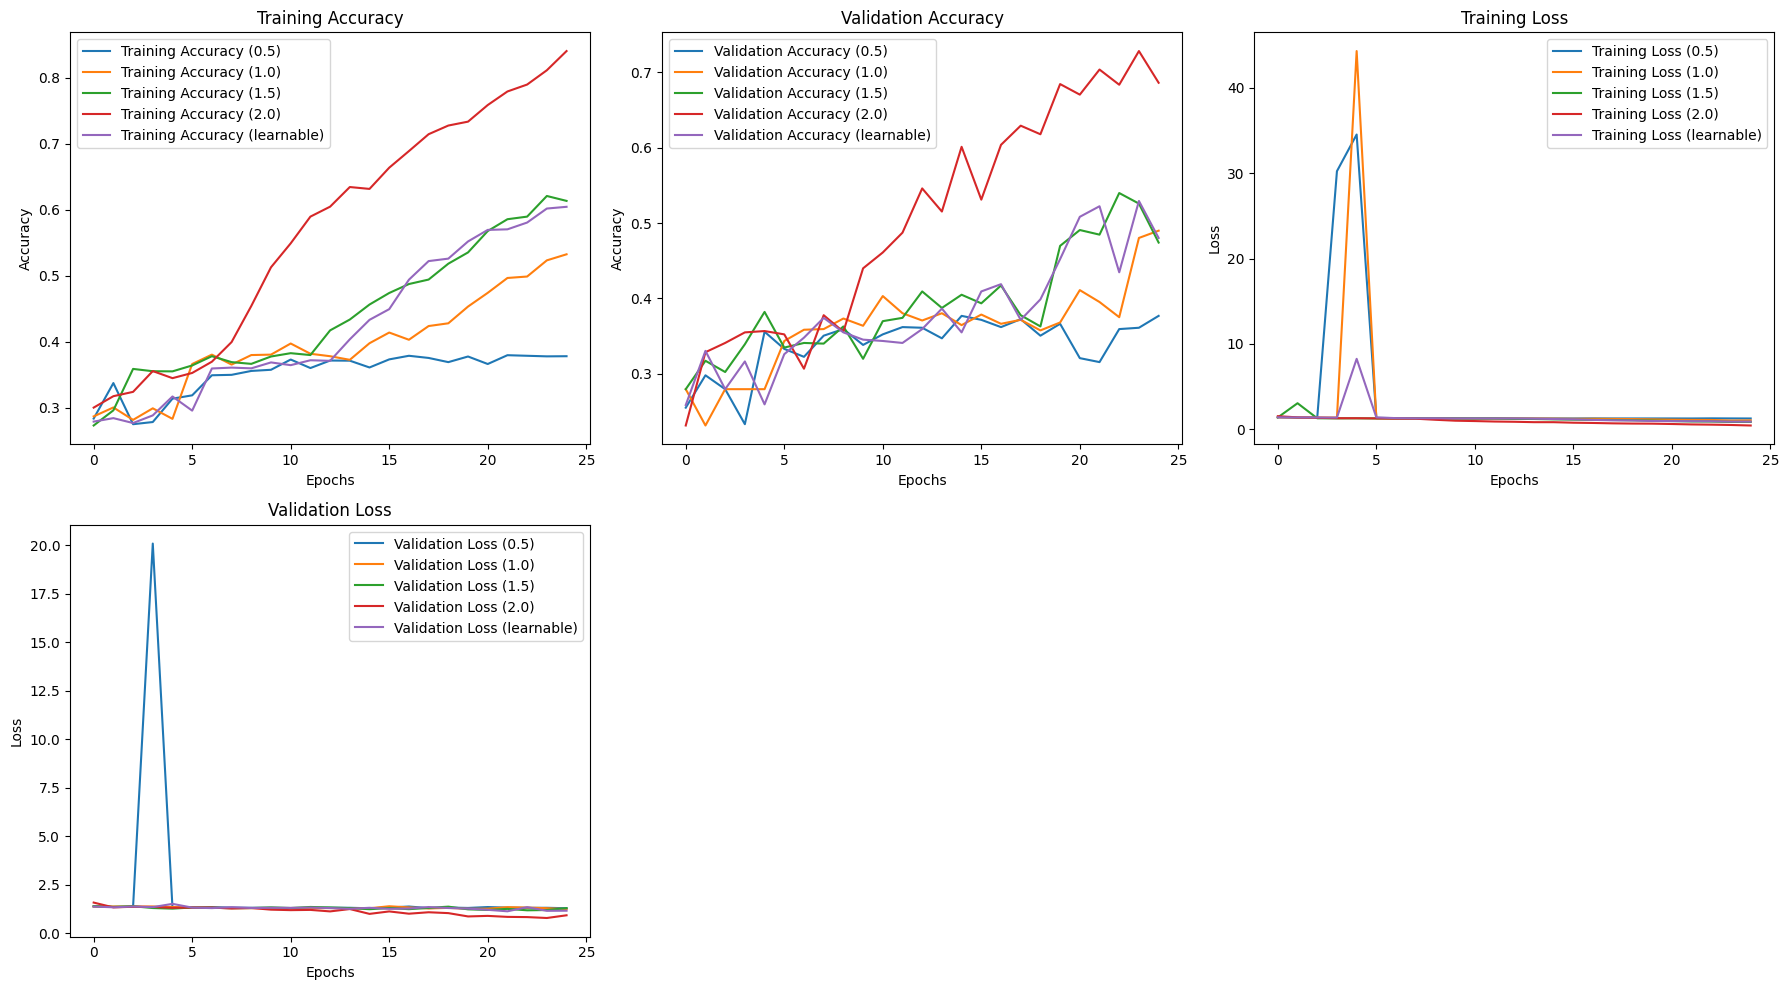

In [ ]:
static_alpha_results.append(history_learnable)
param_labels = [str(label) for label in alpha_values] #Initialize with alpha values
param_labels.append('learnable')
plot_training_history_multiple_models(static_alpha_results, param_labels)

We see that, in the case of the static investigation, the best performing model occured when the value of $ α $ was 2 with the worst perfomer being when the parameter was 0.5. In the case of training accuracy, the model performance improved as we increased the value of this parameter although in the case of the validation data, we saw that whilst $ α=2 $ was still our best model and $ α=0.5 $ was still our worst, the three static models in between these two alpha values generally performed about the same. In the case of the dynamic parameter, we saw minimal success and on the validation data, it performed roughly the same as the mediocre static models.

# 3. Final Model Testing

In this section, we will aggregate the tuned and optimal hyperparameters identified during our tuning process to construct a "best model." Starting with the base architecture inspired by the VGG16 model, we integrate the optimal values for epochs, batch size, learning rate, and the Swish activation parameter—each derived from experiments yielding the best performance for the respective parameter. Whilst this approach does has theoretical floors, as combining individually optimized parameters does not guarantee optimal performance for the final model, it serves as a practical step to synthesize our findings into a unified model. Additionally, the purpose of this investigation was not to produce the best performing model possible but rather to evaluate and visualise the performance of models as we vary their hyperparameters.



# 3.1 Implimentation

Here we'll construct the proposed final model with the following tuned hyperparameters:

1. Epochs = 25
2. Batch Size = 128
3. Exponential Decay Learning Rate
4. Swish parameter, $α$ =2

In [6]:
epoch_count = 25
batch_size = 128
swish_alpha = 2
initial_learning_rate=0.001

As before, we impliment the base VGG16-inspired model with an option to change the value of $ \alpha $, the parameter of the swish function. As mentioned, since our exponential decay learning rate performed the best in our hyperparameter evaluations, we re-impliment this schedule below and then call our function that returns the compiled model.

In [8]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=500,  # Decay over the entire training process
    decay_rate=0.96,          # Reduce by 4% every decay step
    staircase=True            # Decay in discrete steps (instead of continuously)
)

In [9]:
final_model = create_vgg16_swish_model(lr_scheduler=lr_scheduler,swish_alpha=2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Below, using the summary() method on our final model, we get a description of the layout of the model. Here, we can seperate our model into several blocks. In the first block, we have 2 convolutional layers, each with 64 filters. In the second block, we have 2 convolutional layers, each with 128 filters. In the third block, we have 2 convolutional layers, each with 256 filters. In the fourth and fifth block, we have 3 convolutional layers, each with 512 filters. After each block, we have a pooling layer. This is followed by 3 fully connected layers. In total, this leaves us with roughly 11.5 million parameters with about 4 million of these being trainable. This was the same as in our initial model however now, there are roughly an additional 8 million optimiser parameters. See below for an indepth breakdown of the structure of the final network.

In [ ]:
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_4 (Lambda)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_6 (Lambda)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_7 (Lambda)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 11,585,389 (44.19 MB)

 Trainable params: 3,861,796 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,723,593 (29.46 MB)

# 3.2 Training

In this section, we will train the model as we have trained models previously.

In [ ]:
history_final = final_model.fit(train_generator, epochs=epoch_count, validation_data=validation_generator, batch_size = batch_size)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 167ms/step - accuracy: 0.2525 - loss: 1.5216 - val_accuracy: 0.2550 - val_loss: 1.4047
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.2966 - loss: 1.4191 - val_accuracy: 0.3330 - val_loss: 1.3569
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.3419 - loss: 1.3276 - val_accuracy: 0.3602 - val_loss: 1.3596
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.3865 - loss: 1.2735 - val_accuracy: 0.2770 - val_loss: 1.3439
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.3421 - loss: 1.3300 - val_accuracy: 0.3339 - val_loss: 1.3199
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.3533 - loss: 1.2989 - val_accuracy: 0.3260 - val_loss: 1.3298
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.3856 - loss: 1.2682 - val_accuracy: 0.3479 - val_loss: 1.3296
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.3696 - loss: 1.2686 - val

As we see, the final model obtained a validation accuracy that ended on 0.6810 meaning roughly 68% of its predictions were correct on unseen data. Note that, as aforementioned, whilst this model is being considered as the 'final' model, it is not the highest performer we have come across in this section despite using all the tuned parameters. For example, in our investigation of batch sizs, we found that the model that trained on a batch size of 128 obtained a final validation accuracy of 0.7178 (roughly 72%) despite not having tuned the learning rate or the value of $ \alpha $. Likewise, the same occured on our investigation of the parameter $ \alpha $ where despite using a batch size of 32 with a static learning rate, we obtained a validation accuracy of 0.6862.

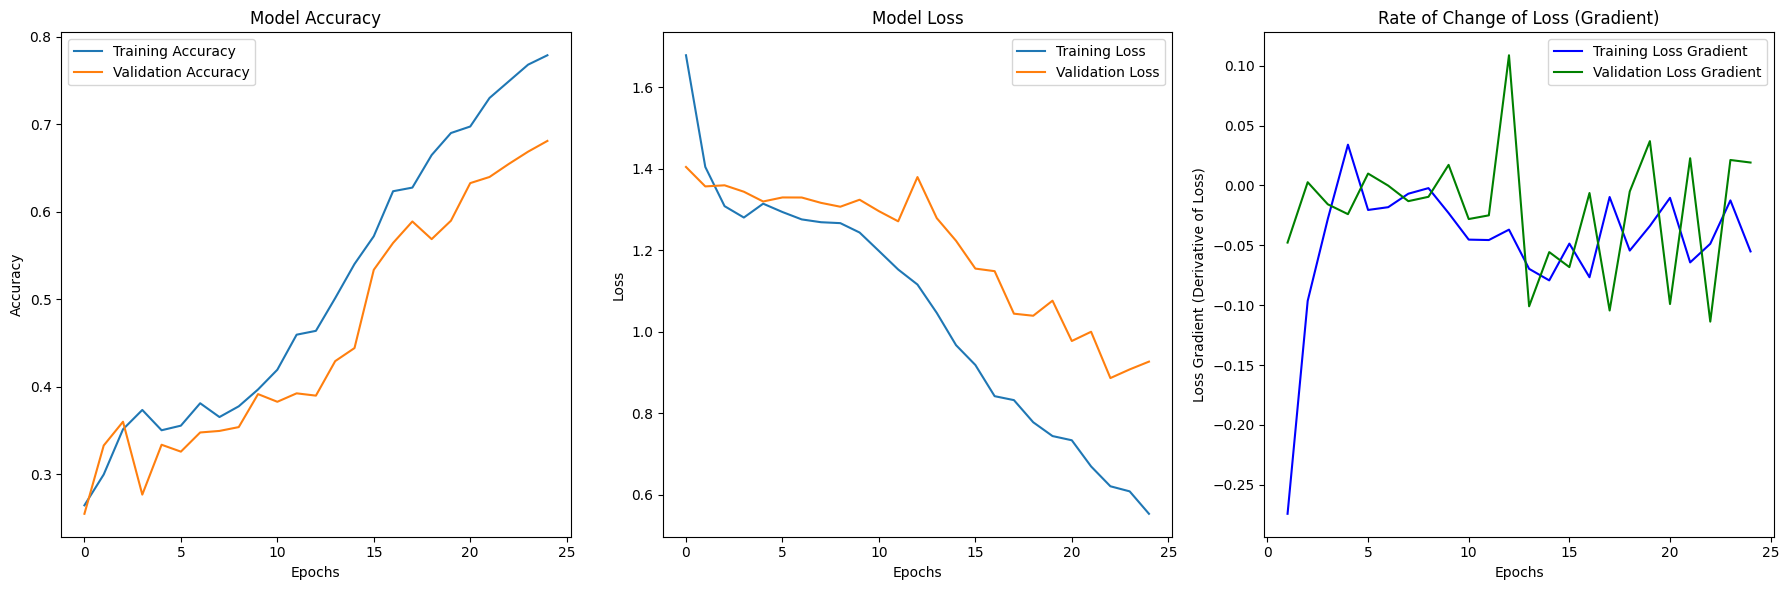

In [ ]:
plot_training_history(history_final)

We see that the model consistently improved its performance over time with its most significant improvement in terms of training(reduction in training loss) occuring early on in training as we see that the rate of change during this period was at its steepest. This would have occured when the learning rate was at its steepest meaning the model was able to take larger steps around the loss landscape. We see that the validation accuracy and training accuracy follow a similar structure of steady improvement although this improvement is not monotonic and during period of training, both validation and training accuracy and loss worsened.

#  3.3 Testing

It is now time to test the model on completely unseen data.

In [ ]:
loss, accuracy = final_model.evaluate(test_generator)

 4/41 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6549 - loss: 1.3788

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6253 - loss: 1.3471


Here, we see that on the test dataset of images, the model was roughly 63% accurate. Let us now consider some examples from the dataset to visualise where the model was correct and where it was incorrect.

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Correct Prediction:
True Label: glioma
Predicted Label: glioma
Class Probabilities:
  glioma: 0.9723
  meningioma: 0.0001
  notumor: 0.0272
  pituitary: 0.0004

Incorrect Prediction:
True Label: glioma
Predicted Label: pituitary
Class Probabilities:
  glioma: 0.0377
  meningioma: 0.1597
  notumor: 0.0032
  pituitary: 0.7995



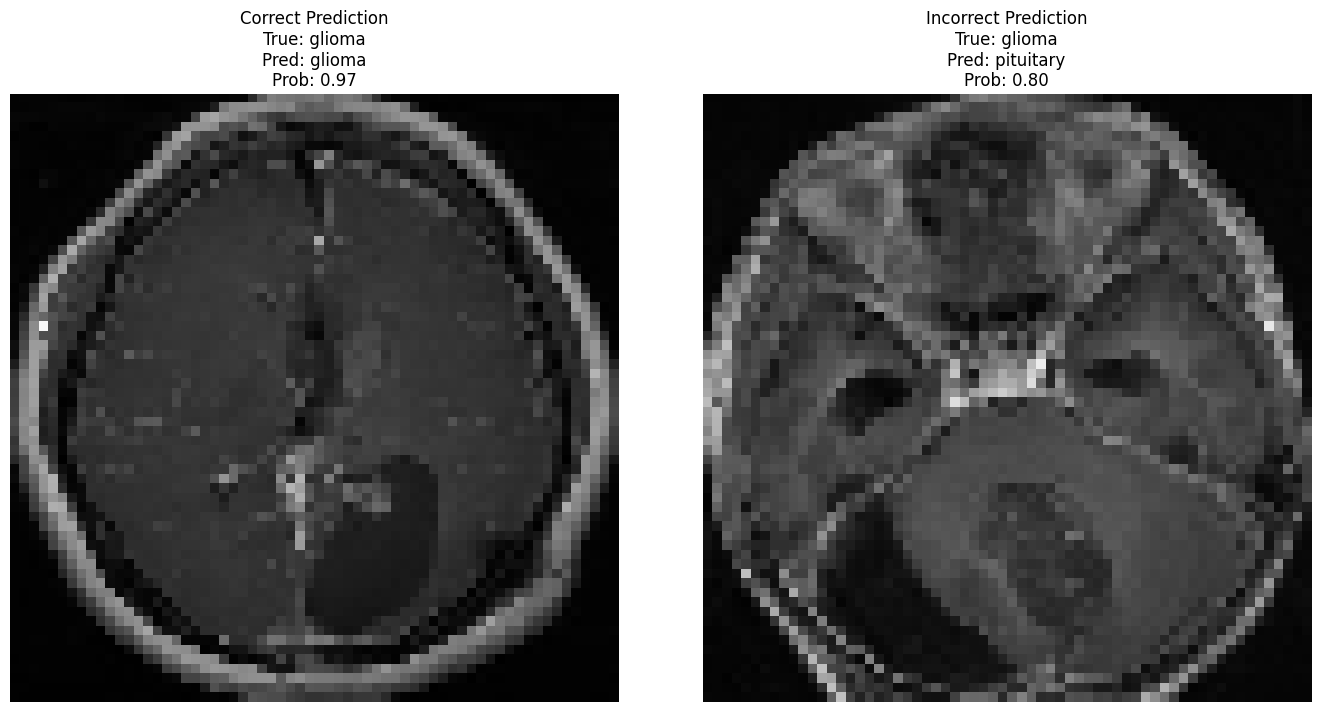

Total Prediction Time: 1.35 seconds
Average Prediction Time per Image: 0.0329 seconds


In [ ]:
# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Predict on the test dataset
start_time = time.time()
predictions = final_model.predict(test_generator)
end_time = time.time()
prediction_time = end_time - start_time

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Find a correct prediction
correct_idx = np.where(predicted_classes == true_classes)[0][0]
correct_image = test_generator[correct_idx][0][0]
correct_true_label = class_labels[true_classes[correct_idx]]
correct_predicted_label = class_labels[predicted_classes[correct_idx]]
correct_probability = predictions[correct_idx, predicted_classes[correct_idx]]

# Find an incorrect prediction
incorrect_idx = np.where(predicted_classes != true_classes)[0][0]
incorrect_image = test_generator[incorrect_idx][0][0]
incorrect_true_label = class_labels[true_classes[incorrect_idx]]
incorrect_predicted_label = class_labels[predicted_classes[incorrect_idx]]
incorrect_probability = predictions[incorrect_idx, predicted_classes[incorrect_idx]]

# Print probability distributions for correct and incorrect predictions
print("Correct Prediction:")
print(f"True Label: {correct_true_label}")
print(f"Predicted Label: {correct_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[correct_idx, i]:.4f}")
print()

print("Incorrect Prediction:")
print(f"True Label: {incorrect_true_label}")
print(f"Predicted Label: {incorrect_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[incorrect_idx, i]:.4f}")
print()

# Plot correct and incorrect predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Correct prediction
axes[0].imshow(correct_image)
axes[0].set_title(
    f"Correct Prediction\nTrue: {correct_true_label}\nPred: {correct_predicted_label}\nProb: {correct_probability:.2f}"
)
axes[0].axis('off')

# Incorrect prediction
axes[1].imshow(incorrect_image)
axes[1].set_title(
    f"Incorrect Prediction\nTrue: {incorrect_true_label}\nPred: {incorrect_predicted_label}\nProb: {incorrect_probability:.2f}"
)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print prediction time
print(f"Total Prediction Time: {prediction_time:.2f} seconds")
print(f"Average Prediction Time per Image: {prediction_time / len(test_generator):.4f} seconds")

On the left, we see a correct prediction. Here the model made a prediction with 97% probability that a particular scan showed a glioma tumor and it was correct in this prediction. On the right, we see an incorrect prediction. Here the model made a prediction with 80% probability that a particular scan showed a pituitary tumor although in this case, this was also glioma. We see that the total prediction time was 1.35 seconds, taking roughly 0.0329 seconds per image.

We see from these photos that they are not of the highest quality resolution and appear rather pixelated. If we recall, in the preprocessing, we reduced the size of the images to speed up testing. Now, we want to consider how this model performs when we increase the size of these images (and as a result, image quality improves) as well as the impact this may have on prediction time.

# 3.4 Scaling Up: Impact of Training on the Full 256x256 Dataset



We begin by performing the exact same processing exept now, IMG_SIZE=256 as opposed to 64. Additionally, since we aren't tuning any parameters, we don't require any validation data which leaves more data for training.

In [ ]:
# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 256  # Resize images to 256x256
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0  # Randomly shift RGB channels (intensity)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
print('Training Data: ')
train_generator_large = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 256x256
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True  # Shuffle data for training
)

print('Testing Data: ')
test_generator_large = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 256x256
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Training Data: 
Found 5712 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


Below, we re-impliment the model however now, the input shape accounts for the larger images that the model will be using to train and test.

In [ ]:
def create_vgg16_swish_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4, initial_learning_rate=0.001, lr_scheduler=None, swish_alpha=1, swish_learnable=False):
    model = models.Sequential()
    if swish_learnable:
        alpha = tf.Variable(initial_value=swish_alpha, trainable=True, dtype=tf.float32)
    else:
        alpha = swish_alpha  # Use the constant value of alpha if not learnable

    # Block 1: 2 Conv layers with 64 filters and Swish activation
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: 2 Conv layers with 128 filters and Swish activation
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: 2 Conv layers with 256 filters and Swish activation
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 5: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from the last convolutional block
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(256))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Dense(256))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax

    # Compile the model with the chosen learning rate and scheduler
    if lr_scheduler:
        model.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
final_model_large = create_vgg16_swish_model(lr_scheduler=lr_scheduler,swish_alpha=swish_alpha)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Once our model has been created. We commence Training below...

In [ ]:
history_final_large = final_model_large.fit(train_generator_large, epochs=epoch_count, batch_size = batch_size)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 676ms/step - accuracy: 0.2524 - loss: 1.5534
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 618ms/step - accuracy: 0.3332 - loss: 1.3396
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 603ms/step - accuracy: 0.3364 - loss: 1.3231
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 611ms/step - accuracy: 0.4377 - loss: 1.1861
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 659ms/step - accuracy: 0.5397 - loss: 1.0201
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 604ms/step - accuracy: 0.6158 - loss: 0.8996
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step - accuracy: 0.6176 - loss: 0.8707
Epoch 8/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 662ms/step - accuracy: 0.6591 - loss: 0.8153
Epoch 9/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 602ms/step - accuracy: 0.6878 - loss: 0.7626
Epoch 10/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 601ms/step - accuracy: 0.6962 - loss: 0.7130
Epoch 11/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 624ms/step - accuracy: 0.7012 - loss: 0.7250
Epoch 12/25
179/179

The training process took significantly longer than when we trained the same model on the smaller images. As we see from the run-time of each epoch, in the larger image model, each epoch took roughly 2 minutes whereas in the smaller image model, each epoch took roughly 20 seconds. However, what we do notice is an improvement in terms of both accuracy and loss. We plot these metrics below:

In [ ]:
def plot_training_history_multiple_models_for_final(histories, labels=None):
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(histories))]
    plt.figure(figsize=(18, 10))

    for i, history in enumerate(histories):
        train_accuracy = history.history['accuracy']
        train_loss = history.history['loss']

        plt.subplot(1, 2, 1)
        plt.plot(train_accuracy, label=f'Training Accuracy ({labels[i]})')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_loss, label=f'Training Loss ({labels[i]})')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

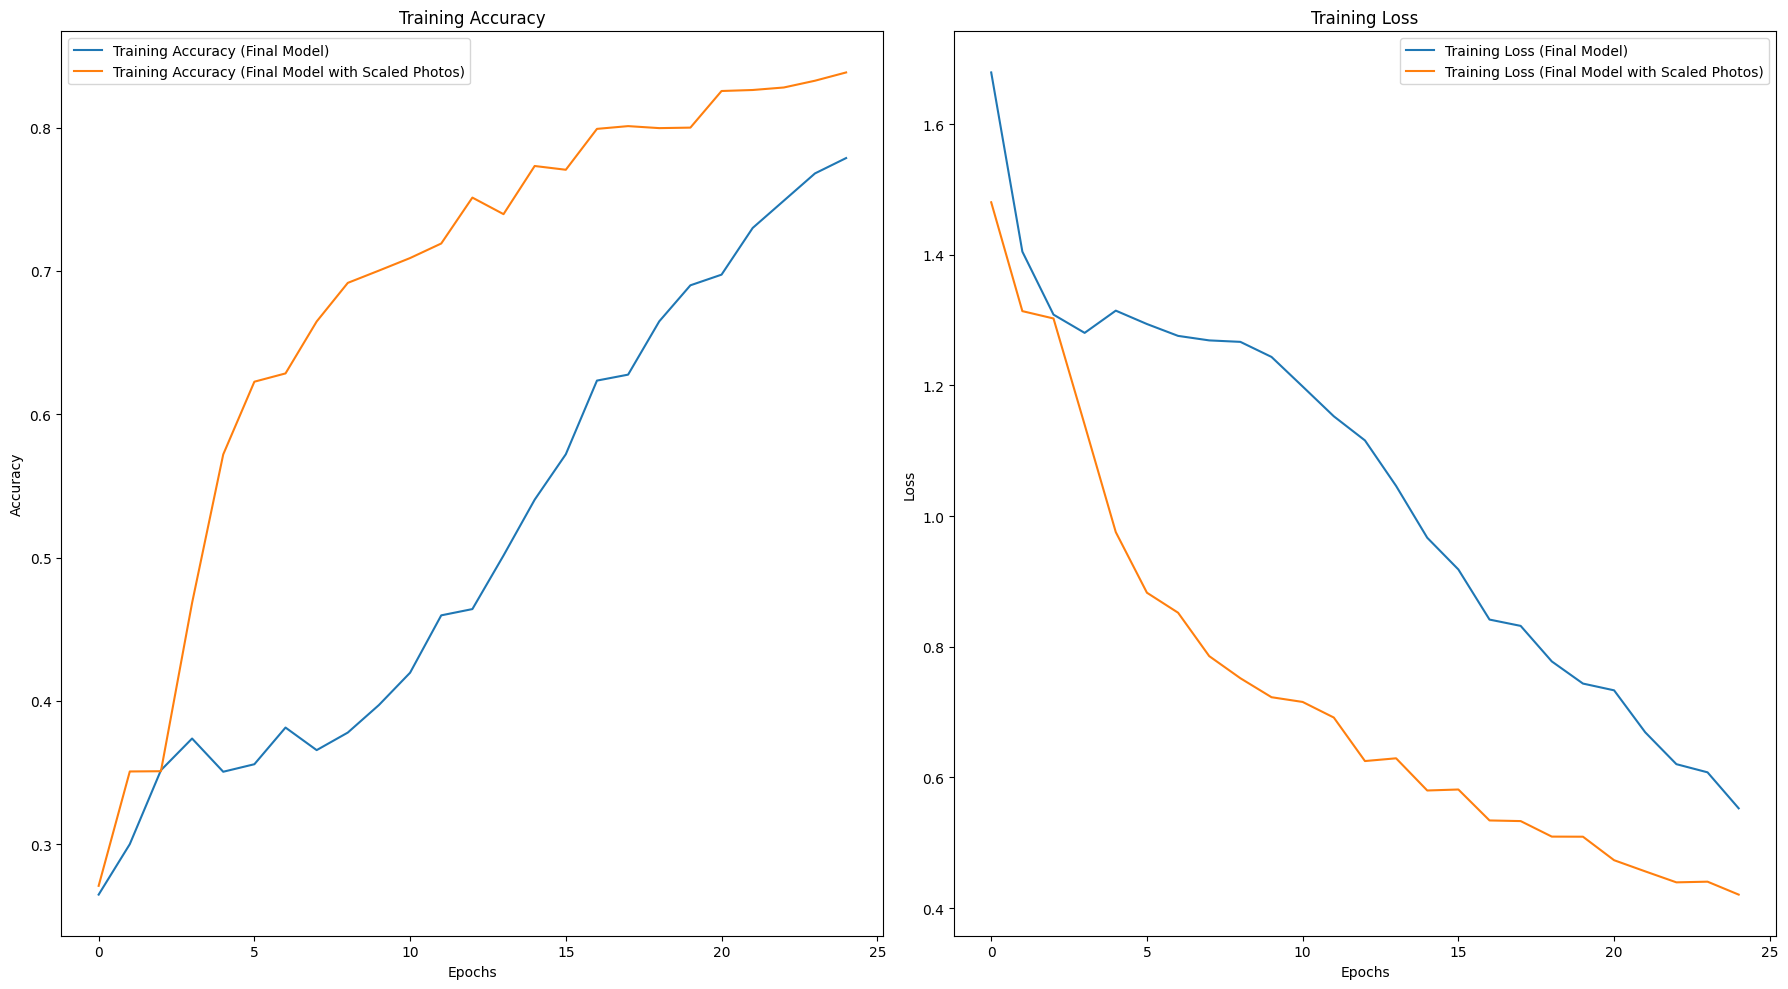

In [ ]:
plot_training_history_multiple_models_for_final([history_final,history_final_large], ['Final Model','Final Model with Scaled Photos'])

As we see from the training plots and from the quantative test results, the models training performance was quite significantly better on the larger images with accuracy higher training and testing scores. Noteably, on the test data, the larger model obtained roughly 84% accururacy in the large image model to 76% on the smaller image model.

In [ ]:
loss, accuracy = final_model_large.evaluate(test_generator_large)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.7868 - loss: 0.4940


Below, as before, we display some images from the test dataset of scaled up images to provide some examples on where the model was correct and where it made mistakes.

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
Correct Prediction:
True Label: glioma
Predicted Label: glioma
Class Probabilities:
  glioma: 0.8894
  meningioma: 0.0294
  notumor: 0.0339
  pituitary: 0.0472

Incorrect Prediction:
True Label: glioma
Predicted Label: meningioma
Class Probabilities:
  glioma: 0.4035
  meningioma: 0.5463
  notumor: 0.0326
  pituitary: 0.0176



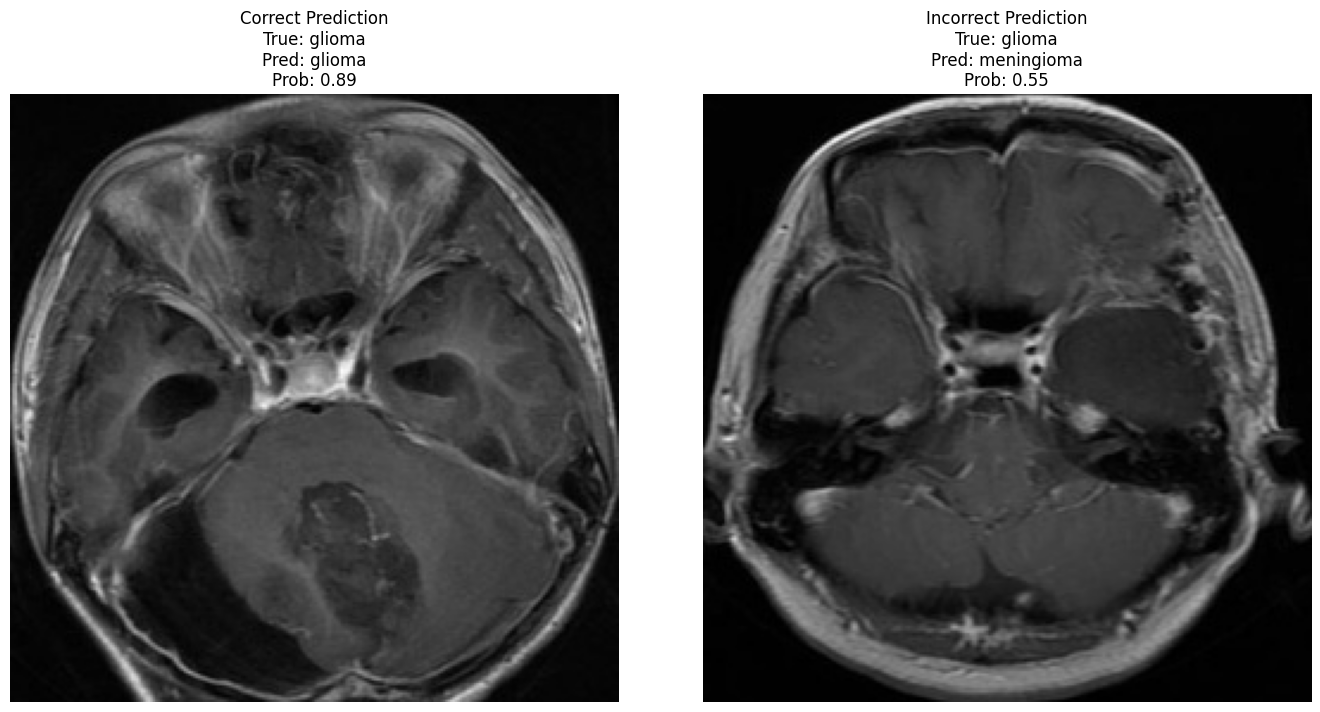

Total Prediction Time: 2.92 seconds
Average Prediction Time per Image: 0.0713 seconds


In [ ]:
# Get class labels
class_labels = list(test_generator_large.class_indices.keys())

# Predict on the test dataset
start_time = time.time()
predictions = final_model_large.predict(test_generator_large)
end_time = time.time()
prediction_time = end_time - start_time

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator_large.classes

# Find a correct prediction
correct_idx = np.where(predicted_classes == true_classes)[0][0]
correct_image = test_generator_large[correct_idx][0][0]
correct_true_label = class_labels[true_classes[correct_idx]]
correct_predicted_label = class_labels[predicted_classes[correct_idx]]
correct_probability = predictions[correct_idx, predicted_classes[correct_idx]]

# Find an incorrect prediction
incorrect_idx = np.where(predicted_classes != true_classes)[0][0]
incorrect_image = test_generator_large[incorrect_idx][0][0]
incorrect_true_label = class_labels[true_classes[incorrect_idx]]
incorrect_predicted_label = class_labels[predicted_classes[incorrect_idx]]
incorrect_probability = predictions[incorrect_idx, predicted_classes[incorrect_idx]]

# Print probability distributions for correct and incorrect predictions
print("Correct Prediction:")
print(f"True Label: {correct_true_label}")
print(f"Predicted Label: {correct_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[correct_idx, i]:.4f}")
print()

print("Incorrect Prediction:")
print(f"True Label: {incorrect_true_label}")
print(f"Predicted Label: {incorrect_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[incorrect_idx, i]:.4f}")
print()

# Plot correct and incorrect predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Correct prediction
axes[0].imshow(correct_image)
axes[0].set_title(
    f"Correct Prediction\nTrue: {correct_true_label}\nPred: {correct_predicted_label}\nProb: {correct_probability:.2f}"
)
axes[0].axis('off')

# Incorrect prediction
axes[1].imshow(incorrect_image)
axes[1].set_title(
    f"Incorrect Prediction\nTrue: {incorrect_true_label}\nPred: {incorrect_predicted_label}\nProb: {incorrect_probability:.2f}"
)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print prediction time
print(f"Total Prediction Time: {prediction_time:.2f} seconds")
print(f"Average Prediction Time per Image: {prediction_time / len(test_generator):.4f} seconds")

The model successfully predicts glioma classification with 89% confidence. However, it incorrectly classifies a glioma scan as meningioma with a 55% probability. Given the low confidence in this incorrect prediction, it is not surprising that the true classification was different.

Additionally, the total prediction time more than doubled, increasing from 1.35 seconds to 2.92 seconds. While this time increase is negligible for research purposes, it could be significant in high-pressure or large-scale environments and may warrant further optimization.

# 4. Conclusion

In this section, we explored the Swish activation function while investigating various factors influencing model performance, including epoch count, batch size, learning rate, and the unique parameter specific to the Swish function. This analysis provided insights into the significance of these factors in enhancing model performance and highlighted cases where performance deteriorated. Notably, although prior research suggests that specific parameter adjustments often lead to performance gains, our experiments revealed that similar improvements were dataset-dependent and not necessarily the case on our dataset.

In conclusion, this section of the report on the swish function has explored the nuanced impact of incorporating a linear term with the sigmoid function. This flexibility of swish with parameter $ \alpha $ and this aforementioned combination of terms works to bridge the previous section of this report, an investigation of ReLU with the next section of the report on the TanH activation function. Whilst Swish approximates the ReLU for low values of $ α $, its flexibility allows it to balance non-linearity and gradient behavior, working to target problems associated with ReLU such as gradient vanishing. As we progress through the report, a natural question might be, 'What happens when we explore the "purely sigmoidal" domain of activation functions?' or 'How does the abscence of the linear term influence the behaviour, weighting and performance of the model?'. This leads us to the following section of the report, namely our investigation on the Tanh activation function. By connecting these activation methods, we highlight a broader understanding of neural activation functions not as isolated mechanisms, but as more of a continious spectrum.




# Appendix

 A: A visual guide to cosine annealing

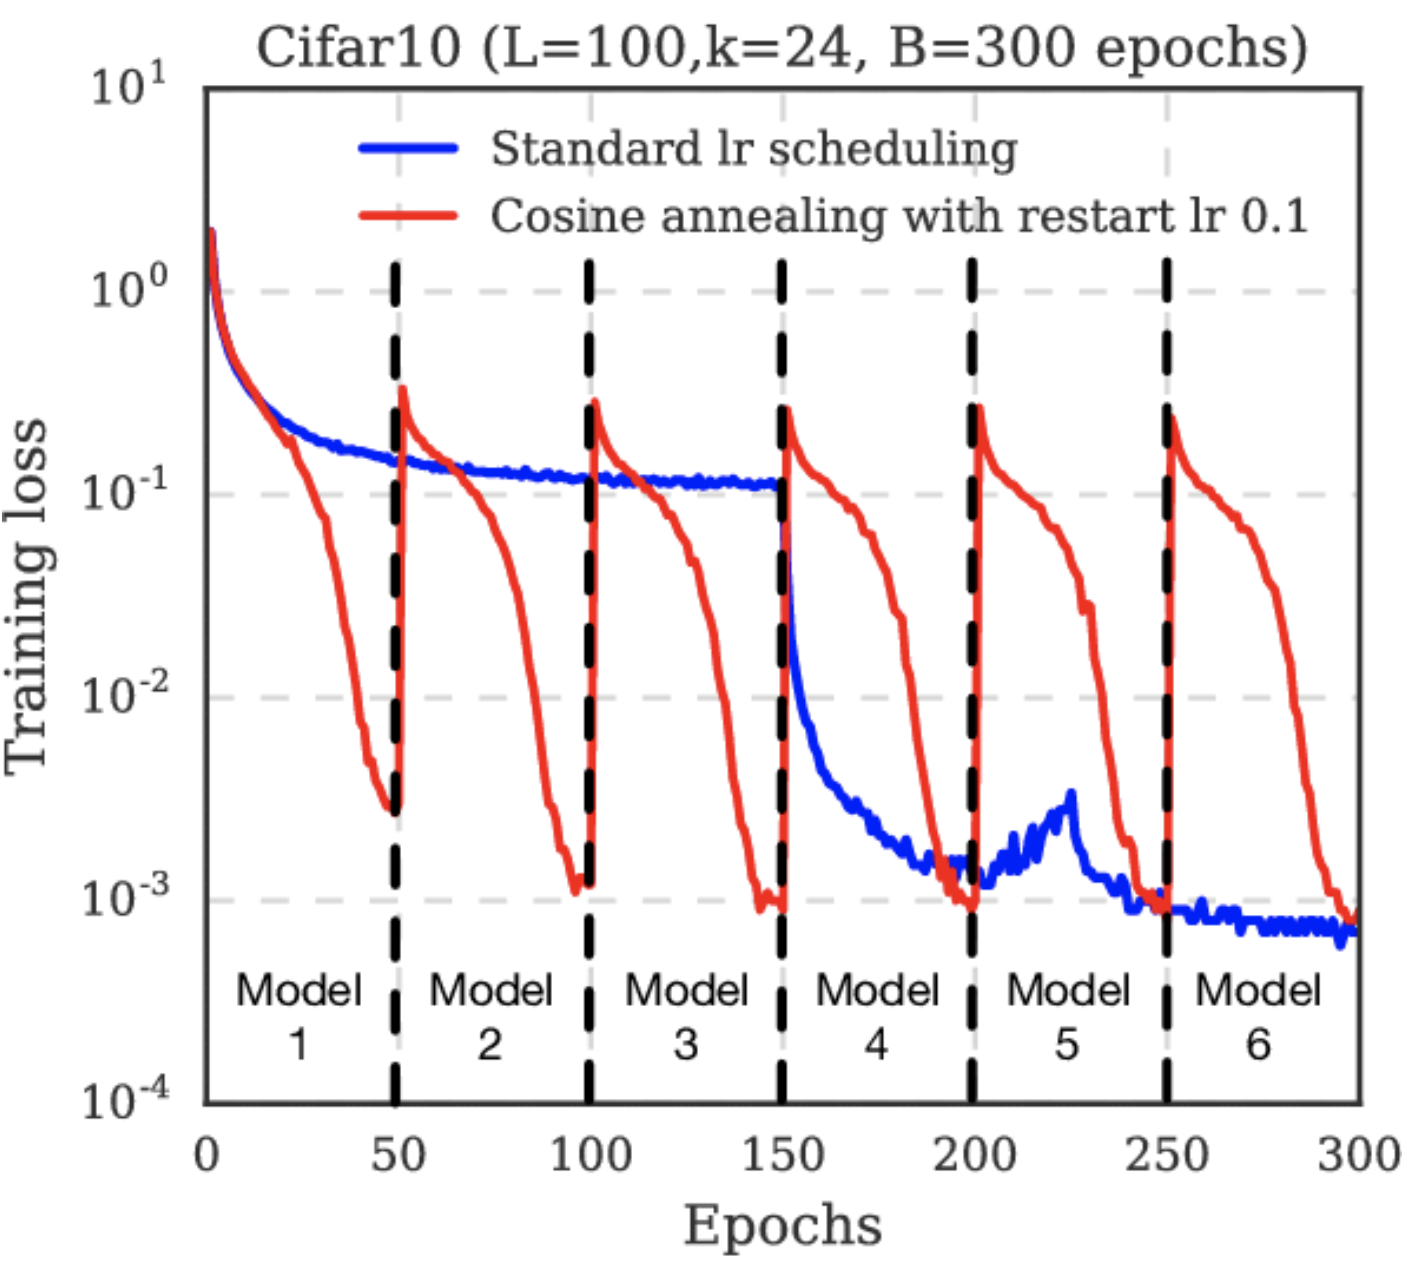

# 5. References

[1] Gustavo, Millen. *Hands-On Machine Learning.* [https://millengustavo.github.io/handson-ml/](https://millengustavo.github.io/handson-ml/).

[2] *ImageNet: A Large-Scale Hierarchical Image Database.* [https://image-net.org/](https://image-net.org/).

[3] Ramachandran, Prajit, et al. "Searching for Activation Functions." *arXiv*, Oct. 2017, [https://arxiv.org/pdf/1710.05941](https://arxiv.org/pdf/1710.05941).

[4] *Swish for Breast Cancer Detection.* https://link.springer.com/chapter/10.1007/978-981-16-1086-8_17

[5] "VGG16 CNN Model." *GeeksforGeeks*, [https://www.geeksforgeeks.org/vgg-16-cnn-model/](https://www.geeksforgeeks.org/vgg-16-cnn-model/).

[6] *Introduction to Swish.* https://dsbristol.github.io/dst/assets/slides/07.1-PerceptronsNeuralNets.pdf

[7] Mazaheri, Saeed, et al. "CRC Image Classification." *Mathematics*, vol. 7, no. 12, 2019, [https://www.mdpi.com/2227-7390/7/12/1170](https://www.mdpi.com/2227-7390/7/12/1170).

[8] "How to Choose Batch Size and Number of Epochs When Fitting a Model." *GeeksforGeeks*, [https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/](https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/).

[9] "Learning Rate." *IEEE Xplore*, 2021, [https://ieeexplore.ieee.org/abstract/document/9344510](https://ieeexplore.ieee.org/abstract/document/9344510).

[10] Smith, Leslie N., et al. "Learning Rate Schedules." *arXiv*, Oct. 2019, [https://arxiv.org/pdf/1910.11605](https://arxiv.org/pdf/1910.11605).

[11] Loshchilov, Ilya, and Frank Hutter. "SGDR: Stochastic Gradient Descent with Warm Restarts." *arXiv*, Aug. 2016, [https://arxiv.org/pdf/1608.03983](https://arxiv.org/pdf/1608.03983).

[12] "Warm Restarts for Optimization." *IEEE Xplore*, 2020, [https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8929465](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8929465).

[13] *ImageNet: A Large-Scale Hierarchical Image Database.* [https://image-net.org/](https://image-net.org/).

[14] *CIFAR Dataset.* [https://www.bing.com/search?q=cifar+dataset](https://www.bing.com/search?q=cifar+dataset).

[15] "Activation Functions in Deep Learning." *arXiv*, Oct. 2018, [https://ar5iv.labs.arxiv.org/html/1810.13243](https://ar5iv.labs.arxiv.org/html/1810.13243).

[16] "Cosine Decay Restarts in TensorFlow." *TensorFlow Documentation*, [https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts).

[17] "Polynomial Decay in TensorFlow." *TensorFlow Documentation*, [https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay).

[18] "Swish Activation Function Analysis." *arXiv*, Jan. 2018, [https://arxiv.org/pdf/1801.07145](https://arxiv.org/pdf/1801.07145).

[19] "Cosine Annealing." *Papers with Code*, [https://paperswithcode.com/method/cosine-annealing](https://paperswithcode.com/method/cosine-annealing).